# Keep only those privileges that speak to your heart
* **Author**: Luis F Monge Martinez (@Lucky-Luk3)
* **Congress**: [SoCON 2025](https://specterops.io/so-con/)
* **Organization**: SpecterOps
* **License**: [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)

## 🔍 Description
This notebook provides an environment for exploring and analyzing Active Directory data using **BloodHound Community** Edition. It connects to BloodHound's API and processes data collected by **SharpHound**, enriching and organizing it for deeper security investigations.


### 📊 Core Features
1. **Data Enrichment & Key Metrics**
2. **Risk Scoring**
3. **Privileged Account Analysis**
4. **Attack Path Exploration**
5. **Root cause analysis**


### 🧠 Future ideas
* Generate execution stadistics
* Calculate scalation paths to all the TIer Zero objects
* User/Group report generator
* Include password age
* Assign different weights to edges

### ⚙️ Requirements
* BloodHound Community Edition (or Enterprise Edition, not tested)
* BH API Key

# Preparation

In [7]:
#@title Download lab files
from IPython.display import clear_output
!wget https://raw.githubusercontent.com/lucky-luk3/SoCON-2025---Keep-only-those-privileges-that-speak-to-your-heart/refs/heads/main/groups.csv
!wget https://raw.githubusercontent.com/lucky-luk3/SoCON-2025---Keep-only-those-privileges-that-speak-to-your-heart/refs/heads/main/users.csv
!wget https://raw.githubusercontent.com/lucky-luk3/SoCON-2025---Keep-only-those-privileges-that-speak-to-your-heart/refs/heads/main/rooted_utils.py
!wget https://raw.githubusercontent.com/lucky-luk3/SoCON-2025---Keep-only-those-privileges-that-speak-to-your-heart/refs/heads/main/mylab.zip
!unzip mylab.zip -d mylab
clear_output()

In [8]:
#@title Requirements
!pip install plotly ipyfilechooser picatrix nest_asyncio ipywidgets ipyfilechooser
clear_output()

In [9]:
#@title Import Libraries
import pandas as pd
import json
import os
import glob
import ipywidgets as widgets
import datetime
import hmac
import hashlib
import base64
import requests
import pandas as pd
import urllib.parse
from picatrix.lib import utils
from ipyfilechooser import FileChooser
from IPython.display import display, clear_output,Markdown
from time import time
from typing import Optional
from tqdm import tqdm

tqdm.pandas()

## BloodHound Community Client

In [10]:
#@title BHClient
class Credentials(object):
    def __init__(self, token_id: str, token_key: str) -> None:
        self.token_id = token_id
        self.token_key = token_key


class APIVersion(object):
    def __init__(self, api_version: str, server_version: str) -> None:
        self.api_version = api_version
        self.server_version = server_version


class Domain(object):
    def __init__(self, name: str, id: str, collected: bool, domain_type: str) -> None: #, impact_value: int
        self.name = name
        self.id = id
        self.type = domain_type
        self.collected = collected
        #self.impact_value = impact_value


class AttackPath(object):
    def __init__(self, id: str, title: str, domain: Domain) -> None:
        self.id = id
        self.title = title
        self.domain_id = domain.id
        self.domain_name = domain.name.strip()

    def __lt__(self, other):
        return self.exposure < other.exposure

class Client(object):
    def __init__(self, scheme: str, host: str, port: int, credentials: Credentials) -> None:
        self._scheme = scheme
        self._host = host
        self._port = port
        self._credentials = credentials

    def _format_url(self, uri: str) -> str:
        formatted_uri = uri
        if uri.startswith("/"):
            formatted_uri = formatted_uri[1:]

        return f"{self._scheme}://{self._host}:{self._port}/{formatted_uri}"

    def _request(self, method: str, uri: str, body: Optional[bytes] = None) -> requests.Response:
        # Digester is initialized with HMAC-SHA-256 using the token key as the HMAC digest key.
        digester = hmac.new(self._credentials.token_key.encode(), None, hashlib.sha256)

        # OperationKey is the first HMAC digest link in the signature chain. This prevents replay attacks that seek to
        # modify the request method or URI. It is composed of concatenating the request method and the request URI with
        # no delimiter and computing the HMAC digest using the token key as the digest secret.
        #
        # Example: GET /api/v1/test/resource HTTP/1.1
        # Signature Component: GET/api/v1/test/resource
        digester.update(f"{method}{uri}".encode())

        # Update the digester for further chaining
        digester = hmac.new(digester.digest(), None, hashlib.sha256)

        # DateKey is the next HMAC digest link in the signature chain. This encodes the RFC3339 formatted datetime
        # value as part of the signature to the hour to prevent replay attacks that are older than max two hours. This
        # value is added to the signature chain by cutting off all values from the RFC3339 formatted datetime from the
        # hours value forward:
        #
        # Example: 2020-12-01T23:59:60Z
        # Signature Component: 2020-12-01T23
        datetime_formatted = datetime.datetime.now().astimezone().isoformat("T")
        digester.update(datetime_formatted[:13].encode())

        # Update the digester for further chaining
        digester = hmac.new(digester.digest(), None, hashlib.sha256)

        # Body signing is the last HMAC digest link in the signature chain. This encodes the request body as part of
        # the signature to prevent replay attacks that seek to modify the payload of a signed request. In the case
        # where there is no body content the HMAC digest is computed anyway, simply with no values written to the
        # digester.
        if body is not None:
            digester.update(json.dumps(body).encode('utf-8'))

        # Perform the request with the signed and expected headers
        return requests.request(
            method=method,
            url=self._format_url(uri),
            headers={
                "User-Agent": "bhe-python-sdk 0002",
                "prefer":"60",
                "Authorization": f"bhesignature {self._credentials.token_id}",
                "RequestDate": datetime_formatted,
                "Signature": base64.b64encode(digester.digest()),
                "Content-Type": "application/json"
            },
            json=body,
        )

    def get_version(self) -> APIVersion:
        response = self._request("GET", "/api/version")
        payload = response.json()

        return APIVersion(api_version=payload["data"]["API"]["current_version"], server_version=payload["data"]["server_version"])

    def get_domains(self):
        response = self._request('GET', '/api/v2/available-domains')
        payload = response.json()['data']

        domains = list()
        #print(payload)
        for domain in payload:
            domains.append(Domain(domain["name"], domain["id"], domain["collected"], domain["type"])) #, domain["impactValue"]

        return domains

    def get_domains_ids(self):
        response = self._request('GET', '/api/v2/available-domains')
        payload = response.json()['data']

        domains = []
        #print(payload)
        for domain in payload:
            domains.append(domain["id"])

        return domains

    def get_users(self, domain_id, limit=200000):
        response = self._request('GET', "/api/v2/domains/{}/users?limit={}".format(domain_id, limit))
        response_data = response.json()
        if "data" in response_data:
            payload = response_data['data']
        else:
            print(f"Error requesting users in {domain_id} domain.")
            payload = ""

        #users = list()
        #print(payload)
        #for domain in payload:
            #domains.append(Domain(domain["name"], domain["id"], domain["collected"], domain["type"])) #, domain["impactValue"]

        return payload

    def get_groups(self, domain_id, limit=200000):
        response = self._request('GET', '/api/v2/domains/{}/groups?limit={}'.format(domain_id, limit))
        response_data = response.json()
        if "data" in response_data:
            payload = response_data['data']
        else:
            print(f"Error requesting groups in {domain_id} domain.")
            payload = ""

        #users = list()
        #print(payload)
        #for domain in payload:
            #domains.append(Domain(domain["name"], domain["id"], domain["collected"], domain["type"])) #, domain["impactValue"]

        return payload

    def get_attack_path_types(self):
        response = self._request('GET', '/api/v2/attack-path-types')
        print(response)
        payload = response.json()['data']

        attack_path_types = list()
        for apt in payload:
            attack_path_types.append(apt)

        return attack_path_types

    def get_paths(self, domain: Domain) -> list:
        response = self._request('GET', '/api/v2/domains/' + domain.id + '/available-types')
        path_ids = response.json()['data']

        paths = list()
        for path_id in path_ids:
            # Get nice title from API and strip newline
            path_title = self._request('GET', '/ui/findings/' + path_id + '/title.md')

            # Create attackpath object
            path = AttackPath(path_id, path_title.text.strip(), domain)
            paths.append(path)

        return paths

    def get_path_principals(self, path: AttackPath) -> list:
        # Get path details from API
        response = self._request('GET', '/api/v2/domains/' + path.domain_id + '/details?finding=' + path.id + '&skip=0&limit=0&Accepted=eq:False')
        payload = response.json()

        # Build dictionary of impacted pricipals
        if 'count' in payload:
            path.impacted_principals = list()
            for path_data in payload['data']:
                # Check for both From and To to determine whether relational or configuration path
                if (path.id.startswith('LargeDefault')):
                    from_principal = path_data['FromPrincipalProps']['name']
                    to_principal = path_data['ToPrincipalProps']['name']
                    principals = {
                        'Group': from_principal,
                        'Principal': to_principal
                    }
                elif ('FromPrincipalProps' in path_data) and ('ToPrincipalProps' in path_data):
                    from_principal = path_data['FromPrincipalProps']['name']
                    to_principal = path_data['ToPrincipalProps']['name']
                    principals = {
                        'Non Tier Zero Principal': from_principal,
                        'Tier Zero Principal': to_principal
                    }
                else:
                    principals = {
                        'User': path_data['Props']['name']
                    }
                path.impacted_principals.append(principals)
                path.principal_count = payload['count']
        else:
            path.principal_count = 0

        return path

    def get_path_timeline(self, path: AttackPath, from_timestamp: str, to_timestamp: str):
        # Sparkline data
        response = self._request('GET', '/api/v2/domains/' + path.domain_id + '/sparkline?finding=' + path.id + '&from=' + from_timestamp + '&to=' + to_timestamp)
        exposure_data = response.json()['data']

        events = list()
        for event in exposure_data:
            e = {}
            e['finding_id'] = path.id
            e['domain_id'] = path.domain_id
            e['path_title'] = path.title
            e['exposure'] = event['CompositeRisk']
            e['finding_count'] = event['FindingCount']
            e['principal_count'] = event['ImpactedAssetCount']
            e['id'] = event['id']
            e['created_at'] = event['created_at']
            e['updated_at'] = event['updated_at']
            e['deleted_at'] = event['deleted_at']

            # Determine severity from exposure
            e['severity'] = self.get_severity(e['exposure'])
            events.append(e)

        return events

    def get_posture(self, from_timestamp: str, to_timestamp: str) -> list:
        response = self._request('GET', '/api/v2/posture-stats?from=' + from_timestamp + '&to=' + to_timestamp)
        payload = response.json()
        return payload["data"]

    def get_severity(self, exposure: int) -> str:
        severity = 'Low'
        if exposure > 40: severity = 'Moderate'
        if exposure > 80: severity = 'High'
        if exposure > 95: severity = 'Critical'
        return severity

    def exec_cypher_query(self, query: str) -> dict:
        body = {"query": query}
        response = self._request('POST', '/api/v2/graphs/cypher', body=body)
        if "data" in response.json():
            payload = response.json()['data']
        else:
            print("No data")
            payload = response

        #nodes = []
        #for d in payload["nodes"]:
            #nodes.append(payload["nodes"][d])

        #edges = []
        #for d in payload["edges"]:
            #edges.append(d)

        #df_nodes = pd.DataFrame.from_records(nodes)
        #df_edges = pd.DataFrame.from_records(edges)

        #return df_nodes, df_edges

        #nodes = payload["nodes"]

        #domains = list()
        #print(payload)
        #for domain in payload:
            #domains.append(Domain(domain["name"], domain["id"], domain["collected"], domain["type"])) #, domain["impactValue"]

        return payload

    def search(self, query: str) -> pd.DataFrame:
        body = urllib.parse.quote(query)
        response = self._request('GET', f'/api/v2/search?q={body}')
        payload = response.json()['data']
        results = []
        for d in payload:
            results.append(d)
        df_result = pd.DataFrame.from_records(results)

        return df_result


    def get_data_quality_stats(self, domain_id: str) -> dict:
        response = self._request('GET', f'/api/v2/ad-domains/{domain_id}/data-quality-stats?limit=100')
        payload = response.json()['data']

        return payload


    def get_shortest_path(self, start_node: str, end_node: str, relationship_kinds: Optional[list] = None) -> pd.DataFrame:
        if relationship_kinds == None:
            relationship_kinds = urllib.parse.quote("in:Owns,GenericAll,GenericWrite,WriteOwner,WriteDacl,MemberOf,ForceChangePassword,AllExtendedRights,AddMember,HasSession,Contains,GPLink,AllowedToDelegate,TrustedBy,AllowedToAct,AdminTo,CanPSRemote,ExecuteDCOM,HasSIDHistory,AddSelf,DCSync,ReadLAPSPassword,ReadGMSAPassword,DumpSMSAPassword,SQLAdmin,AddAllowedToAct,WriteSPN,AddKeyCredentialLink,SyncLAPSPassword,WriteAccountRestrictions")
        else:
            relationship_kinds = urllib.parse.quote(relationship_kinds)
        response = self._request('GET', f'/api/v2/graphs/shortest-path?start_node={start_node}&end_node={end_node}&relationship_kinds={relationship_kinds}')
        if 'data' in response.json():
            payload = response.json()['data']
        else:
            print(response.json())

        nodes = []
        edges = []
        for key in payload["nodes"].keys():
            temp = payload["nodes"][key]
            temp["id"] = key
            nodes.append(temp) #    nodes.append(data["nodes"][d])

        for d in payload["edges"]:
            edges.append(d)

        df_nodes = pd.DataFrame.from_records(nodes, index="id")
        df_edges = pd.DataFrame.from_records(edges)

        return df_nodes, df_edges

    def get_user_ncontrollers(self, user_id):
        response = self._request('GET', '/api/v2/users/{}/controllers?limit=1'.format(user_id))
        n = response.json()['count']

        return n

    def get_user_controllers(self, user_id):
        response = self._request('GET', '/api/v2/users/{}/controllers?limit=10000'.format(user_id))
        controllers = response.json()['data']

        df_controllers = pd.DataFrame.from_records(controllers)

        return df_controllers

    def get_user_ncontrollables(self, user_id):
        response = self._request('GET', '/api/v2/users/{}/controllables?limit=1'.format(user_id))
        n = response.json()['count']

        return n

    def get_user_controllables(self, user_id):
        response = self._request('GET', '/api/v2/users/{}/controllables?limit=10000'.format(user_id))
        controllables = response.json()['data']

        df_controllables = pd.DataFrame.from_records(controllables)

        return df_controllables

    def get_group_ncontrollables(self, group_id):
        response = self._request('GET', '/api/v2/groups/{}/controllables'.format(group_id))
        n = response.json()['count']

        return n

    def get_group_controllables(self, group_id):
        response = self._request('GET', '/api/v2/groups/{}/controllables'.format(group_id))
        controllables = response.json()['data']

        df_controllables = pd.DataFrame.from_records(controllables)
        #users = list()
        #print(payload)
        #for domain in payload:
            #domains.append(Domain(domain["name"], domain["id"], domain["collected"], domain["type"])) #, domain["impactValue"]

        return n

    def get_group_ncontrollers(self, group_id):
        response = self._request('GET', '/api/v2/groups/{}/controllers?limit=1'.format(group_id))
        n = response.json()['count']

        return n

    def get_group_controllers(self, group_id):
        response = self._request('GET', '/api/v2/groups/{}/controllers?limit=10000'.format(group_id))
        controllers = response.json()['data']

        df_controllers = pd.DataFrame.from_records(controllers)

        return df_controllers

    def get_group_nmembers(self, group_id):
        response = self._request('GET', '/api/v2/groups/{}/members'.format(group_id))
        n = response.json()['count']

        return n

    def get_user_membership(self, user_id):
        response = self._request('GET', '/api/v2/users/{}/memberships?limit=10000'.format(user_id))
        memberships = response.json()['data']

        #df_controllables = pd.DataFrame.from_records(controllables)
        #users = list()
        #print(payload)
        #for domain in payload:
            #domains.append(Domain(domain["name"], domain["id"], domain["collected"], domain["type"])) #, domain["impactValue"]

        return memberships

    def get_user_attrib(self, user_id, attrib):
        response = self._request('GET', '/api/v2/users/{}'.format(user_id))
        attribute = response.json()['data']['props'][attrib]

        return attribute

    def get_user_enabled(self, user_id):
        response = self._request('GET', '/api/v2/users/{}'.format(user_id))
        props = response.json()['data']['props']
        if 'enabled' in props:
            attribute = response.json()['data']['props']['enabled']
        else:
            attribute = 'error'

        return attribute

In [11]:
#@title Main functions
from rooted_utils import get_user_ncontrollables,get_user_ncontrollers,get_group_ncontrollables,get_group_ncontrollers,get_user_info,get_user_infov2,get_group_infov2,get_group_members
import multiprocessing

def bh_connect(BHE_TOKEN_ID, BHE_TOKEN_KEY, BHE_SCHEME, BHE_DOMAIN, BHE_PORT):

    credentials = Credentials(
        token_id=BHE_TOKEN_ID,
        token_key=BHE_TOKEN_KEY,
    )

    client = Client(scheme=BHE_SCHEME, host=BHE_DOMAIN, port=BHE_PORT, credentials=credentials)
    try:
        version = client.get_version()
        print("Connection OK!")
    except:
        print("Error conecting to BH")

    return client

def process_users(client, domains, limit=200000):
    #list of domains
    users = []
    for domain in domains:
        users.extend( client.get_users(domain, limit))
    #print(users)
    df_users = pd.DataFrame.from_records(users)

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(get_user_ncontrollables, df_users["objectID"])
    df_users["ncontrollables"] = results

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(get_user_ncontrollers, df_users["objectID"])
    df_users["ncontrollers"] = results

    df_users["control_risk"] = df_users["ncontrollables"] * (df_users["ncontrollers"]) #Test other combinations
    #df_users["ncontrollables"] = df_users[:10]["objectID"].apply(client.get_user_ncontrollables)
    #df_users["ncontrollers"] = df_users[:10]["objectID"].apply(client.get_user_ncontrollers)


    return df_users

def process_usersv2(client, domains, df_users_init, limit=200000):

    df_users_init = df_users_init.rename(columns={'ObjectIdentifier':'objectID'})
    rows = df_users_init[:limit].to_dict('records')

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(get_user_infov2, rows)

    df_users = pd.DataFrame.from_records([r for r in results if r is not None])
    #df_users = pd.DataFrame.from_records(results, index='objectid')
    #df_users = pd.DataFrame.from_records(results)

    #df_users["control_risk"] = df_users["controllables"] * (df_users["controllers"])

    return df_users

def process_groups(client, domains, limit=200000):
    #list of domains
    groups = []
    for domain in domains:
        groups.extend( client.get_groups(domain, limit))

    df_groups = pd.DataFrame.from_records(groups)
    #df_groups["ncontrollables"] = df_groups[:10]["objectID"].apply(client.get_group_ncontrollables)
    #df_groups["ncontrollers"] = df_groups[:10]["objectID"].apply(client.get_group_ncontrollers)

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(get_group_ncontrollables, df_groups["objectID"])
    df_groups["ncontrollables"] = results

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(get_group_ncontrollers, df_groups["objectID"])
    df_groups["ncontrollers"] = results

    df_groups["control_risk"] = df_groups["ncontrollables"] * (df_groups["ncontrollers"]) #Test other combinations

    return df_groups

def process_groupsv2(client, domains, df_groups_init, limit=200000):

    df_groups_init = df_groups_init.rename(columns={'ObjectIdentifier':'objectID'})
    rows = df_groups_init[:limit].to_dict('records')
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(get_group_infov2, rows)

    #df_groups = pd.DataFrame.from_records(results, index='objectid')
    df_groups = pd.DataFrame.from_records(results)

    return df_groups

def processBHfolder(path):
    data = {}
    json_files = glob.glob(os.path.join(path, "*.json"))
    for file in json_files:
        #print(f"Processing file: {file}.")
        filename = os.path.basename(file).replace(".json", "")
        suf = filename.split("_")[-1]

        with open(file, 'r', encoding='utf-8') as f:
            content = json.load(f)

        if "data" in content:
            if suf in data:
                data[f"{suf}"].extend(content["data"])
            else:
                data[f"{suf}"] = content["data"]
        else:
            print(f"Advertencia: La clave 'data' no se encontró en {nombre_archivo}.")
    return data

def processData(JSONdata):
    result = {}
    result["domains_hashes"] = {}
    result["domains_names"] = {}
    result["ous_hashes"] = {}
    result["ous_names"] = {}
    result["ous_names"] = {}
    result["users_names"]= {}
    result["groups_names"]= {}


    for domain in JSONdata["domains"]:
        for hash in domain["InheritanceHashes"]:
            if hash in result["domains_hashes"]:
                result["domains_hashes"][hash].append(domain['Properties']['distinguishedname'])
            else:
                result["domains_hashes"][hash] = [domain['Properties']['distinguishedname']]
        result["domains_names"][domain['ObjectIdentifier']] = domain['Properties']['name']

    for ou in JSONdata["ous"]:
        for hash in ou["InheritanceHashes"]:
            if hash in result["ous_hashes"]:
                result["ous_hashes"][hash].append(ou['Properties']['distinguishedname'])
            else:
                result["ous_hashes"][hash] = [ou['Properties']['distinguishedname']]
        result["ous_names"][ou['ObjectIdentifier']] = ou['Properties']['name']

    for group in JSONdata["groups"]:
        result["groups_names"][group['ObjectIdentifier']] = group['Properties']['name']

    users_init = []
    for user in JSONdata["users"]:
        result["users_names"][user['ObjectIdentifier']] = user['Properties']['name']
        properties = user.get('Properties', {})

        row = {}
        for key in user:
            if key not in ['Properties']:
                row[key] = user[key]

        for key in properties:
            row[key] = properties[key]

        users_init.append(row)

    df_users_init = pd.DataFrame.from_records(users_init)

    groups_init = []
    for group in JSONdata["groups"]:
        result["groups_names"][user['ObjectIdentifier']] = group['Properties']['name']
        properties = group.get('Properties', {})

        row = {}
        for key in group:
            if key not in ['Properties']:
                row[key] = group[key]

        for key in properties:
            row[key] = properties[key]

        groups_init.append(row)

    df_groups_init = pd.DataFrame.from_records(groups_init)

    return result, df_users_init, df_groups_init

In [12]:
#@title Menu
# CONFIG MENU
display(Markdown(f"# CONFIG"))
display(Markdown(f"## BloodHound CE BHE_TOKEN_ID, BHE_TOKEN_KEY are necessary and folder with RAW files as well."))

bh_ip_text = widgets.Text(
    value='40.160.2.158',
    placeholder='BloodHound IP/Domain',
    description='BloodHound IP/Domain:',
    style={'description_width': 'initial'}
)


bh_port_text = widgets.BoundedIntText(
    value=8080,
    max=25365,
    #placeholder='BloodHound port',
    description='BloodHound port:',
    style={'description_width': 'initial'}
)

bh_scheme_text = widgets.Text(
    value='',
    placeholder='http',
    description='BloodHound scheme:',
    style={'description_width': 'initial'}
)

bh_scheme_text.value = "http"

token_id_text = widgets.Text(
    value='',
    placeholder='Token ID',
    description='Token ID:',
    style={'description_width': 'initial'}
)

token_id_text.value = "95be41a7-0411-4aa3-a0f4-dbe1ab99e8d5"

token_key_text = widgets.Text(
    value='',
    placeholder='Token key',
    description='Token key:',
    style={'description_width': 'initial'}
)

token_key_text.value = "gkdwNS36+tPbhW/6lNAke4l7Bh6Ud0hDY4aH71wjw8vS9X/o7vBF2w=="

fc = FileChooser()
fc.show_only_dirs = True
fc.show_hidden = True
fc.use_dir_icons = True
fc.title = "<b>Select folder with SharpHound JSON files</b>"

save_data_selector = widgets.Checkbox(
    value=False,
    description='Use saved data',
    disabled=False,
    indent=False
)

button_process_data = widgets.Button(
    description='Process data',
    button_style='primary'
)

# Área de salida para mostrar el contenido
output = widgets.Output()

def process_data(b):
    with output:
        clear_output()  # Limpiar la salida antes de mostrar nuevos datos
        ruta_carpeta = fc.selected_path
        display(Markdown(f"Procesando datos en la carpeta: **{ruta_carpeta}**"))
        start_time = time()
        # RAW processing
        data = processBHfolder(ruta_carpeta)
        result, df_users_init, df_groups_init = processData(data)
        utils.ipython_bind_global('processed_json', result)
        display(Markdown(f"Processed data stored in **processed_json**"))
        utils.ipython_bind_global('rawdata_json', data)
        display(Markdown(f"Processed data stored in **rawdata_json**"))
        utils.ipython_bind_global('df_users_init', df_users_init)
        display(Markdown(f"Processed users stored in **df_users_init**"))
        utils.ipython_bind_global('df_groups_init', df_groups_init)
        display(Markdown(f"Processed groups stored in **df_groups_init**"))

        # Processing BH Data
        client = bh_connect(token_id_text.value, token_key_text.value, bh_scheme_text.value, bh_ip_text.value, bh_port_text.value)
        utils.ipython_bind_global('client', client)
        display(Markdown(f"BH client stored in **client**"))


        # Users with ncontrollers and ncontrollables
        if save_data_selector.value:
            df_users = pd.read_csv("users.csv")
            display(Markdown(f"Processed users previously stored in file \'users.csv\'."))
            df_groups = pd.read_csv("groups.csv")
            display(Markdown(f"Processed users previously stored in file \'groups.csv\'."))

        else:
            domains = client.get_domains_ids()
            df_users = process_usersv2(client, domains, df_users_init)
            utils.ipython_bind_global('df_users', df_users)
            display(Markdown(f"Processed users stored in **df_users** variable."))

            df_groups = process_groupsv2(client, domains, df_groups_init)
            utils.ipython_bind_global('df_groups', df_groups)
            display(Markdown(f"Processed users stored in **df_groups** variable."))

            #Cleaning errors in users
            if "objectid" in df_users.columns:
                df_users = df_users.dropna(subset=['objectid'])
            df_users = df_users[~df_users['whencreated'].isna()]
            #Tier zero
            #df_users['admin_tier_0'] = df_users['system_tags'].str.contains('admin_tier_0')
            #df_users['admin_tier_0'] = df_users['admin_tier_0'].fillna(False)
            #Cleaning errors in groups
            if "objectid" in df_groups.columns:
                df_groups = df_groups.dropna(subset=['objectid'])

            #Tier zero
            df_groups['admin_tier_0'] = df_groups['system_tags'].str.contains('admin_tier_0')
            df_groups['admin_tier_0'] = df_groups['admin_tier_0'].fillna(False)

            #borrar
            #df_groups['path_da_nedges'] = df_groups['path_da_nedges'].fillna(0)
            #df_groups["control_risk"] = (df_groups["controllables"]+1) * (df_groups["controllers"]+1) * (df_groups["path_da_nedges"]+1) * (df_groups["members"]+1)

            df_users["controllables_norm"]=(df_users["controllables"]-df_users["controllables"].min())/(df_users["controllables"].max()-df_users["controllables"].min())
            df_users["controllers_norm"]=(df_users["controllers"]-df_users["controllers"].min())/(df_users["controllers"].max()-df_users["controllers"].min())
            df_users["path_da_nedges_norm"]=(df_users["path_da_nedges"]-df_users["path_da_nedges"].min())/(df_users["path_da_nedges"].max()-df_users["path_da_nedges"].min())
            df_users["sessions_norm"]=(df_users["sessions"]-df_users["sessions"].min())/(df_users["sessions"].max()-df_users["sessions"].min())


            df_groups["controllables_norm"]=(df_groups["controllables"]-df_groups["controllables"].min())/(df_groups["controllables"].max()-df_groups["controllables"].min())
            df_groups["controllers_norm"]=(df_groups["controllers"]-df_groups["controllers"].min())/(df_groups["controllers"].max()-df_groups["controllers"].min())
            df_groups["path_da_nedges_norm"]=(df_groups["path_da_nedges"]-df_groups["path_da_nedges"].min())/(df_groups["path_da_nedges"].max()-df_groups["path_da_nedges"].min())
            df_groups["members_norm"]=(df_groups["members"]-df_groups["members"].min())/(df_groups["members"].max()-df_groups["members"].min())
            df_groups["sessions_norm"]=(df_groups["sessions"]-df_groups["sessions"].min())/(df_groups["sessions"].max()-df_groups["sessions"].min())

            #In path to DA
            uniq_nodes = {}
            for index, row in df_users.iterrows():
                for e in row["path_da_nodes_oidlist"]:
                    if e in uniq_nodes:
                        uniq_nodes[e] = uniq_nodes[e]+1
                    else:
                        uniq_nodes[e] = 1

            for index, row in df_groups.iterrows():
                for e in row["path_da_nodes_oidlist"]:
                    if e in uniq_nodes:
                        uniq_nodes[e] = uniq_nodes[e]+1
                    else:
                        uniq_nodes[e] = 1

            df_users["n_in_path_da"]= df_users["objectid"].map(uniq_nodes)
            df_users['n_in_path_da'] = df_users['n_in_path_da'].fillna(0)
            df_users["n_in_path_da_norm"]=(df_users["n_in_path_da"]-df_users["n_in_path_da"].min())/(df_users["n_in_path_da"].max()-df_users["n_in_path_da"].min())

            df_groups["n_in_path_da"]= df_groups["objectid"].map(uniq_nodes)
            df_groups['n_in_path_da'] = df_groups['n_in_path_da'].fillna(0)
            df_groups["n_in_path_da_norm"]=(df_groups["n_in_path_da"]-df_groups["n_in_path_da"].min())/(df_groups["n_in_path_da"].max()-df_groups["n_in_path_da"].min())

            # Groups - Mean users controllables - group controllables
            from rooted_utils import get_group_members

            df_users_controllables = df_users[["objectid","controllables"]]

            with multiprocessing.Pool(processes=multiprocessing.cpu_count()-1) as pool:
                results = pool.map(get_group_members, df_groups["objectid"])
            df_groups["members_list"] = results

            def get_mem_mean(members):
                mean= df_users_controllables[df_users_controllables['objectid'].isin(members)].controllables.mean()
                return mean

            df_groups['members_controllables_mean'] = df_groups["members_list"].apply(get_mem_mean)
            df_groups['users_mean-group_control'] = df_groups['members_controllables_mean'] - df_groups['controllables']
            df_groups["users_mean-group_control_norm"] = 1 - ((df_groups["users_mean-group_control"] - df_groups["users_mean-group_control"].min()) / (df_groups["users_mean-group_control"].max() - df_groups["users_mean-group_control"].min()))
            df_groups["users_mean-group_control_norm"].fillna(0, inplace=True)

            df_groups = df_groups.drop(columns=['members_list'])

            #Risk
            ##Users
            df_users["control_risk"] = (df_users["controllables"]) + (df_users["controllers"]) + (df_users["path_da_nedges"]) + (df_users["n_in_path_da"]) + (df_users["sessions"])
            df_users["control_risk_norm"] = (df_users["controllables_norm"]*1) + (df_users["controllers_norm"]*1) + (df_users["path_da_nedges_norm"]*1) + (df_users["n_in_path_da_norm"]*1)+ (df_users["sessions_norm"]*1)
            total_risk_norm_users = df_users['control_risk_norm'].sum()
            df_users['control_risk_norm_100'] = ((df_users['control_risk_norm'] / total_risk_norm_users) * 100)
            total_risk_users = df_users['control_risk'].sum()
            df_users['control_risk_100'] = (df_users['control_risk'] / total_risk_users) * 100
            ##Groups
            df_groups["control_risk"] = (df_groups["controllables"]) + (df_groups["controllers"]) + (df_groups["path_da_nedges"]) + (df_groups["members"]) + (df_groups["n_in_path_da"]) + (df_groups["sessions"])
            df_groups["control_risk_norm"] = (df_groups["controllables_norm"]*1) + (df_groups["controllers_norm"]*1) + (df_groups["path_da_nedges_norm"]*1) + (df_groups["members_norm"]*1) + (df_groups["n_in_path_da_norm"]*1) + (df_groups["users_mean-group_control_norm"]*1) + (df_groups["sessions_norm"]*1)
            total_risk_norm_groups = df_groups['control_risk_norm'].sum()
            df_groups['control_risk_norm_100'] = ((df_groups['control_risk_norm'] / total_risk_norm_groups) * 100)
            total_risk_groups = df_groups['control_risk'].sum()
            df_groups['control_risk_100'] = (df_groups['control_risk'] / total_risk_groups) * 100


            #Store in files
            df_users.to_csv("users.csv")
            display(Markdown(f"Processed users has being stored in file \'users.csv\'."))
            df_groups.to_csv("groups.csv")
            display(Markdown(f"Processed groups has being stored in file \'groups.csv\'."))

        utils.ipython_bind_global('df_users', df_users)
        display(Markdown(f"Processed users stored in **df_users** variable."))
        utils.ipython_bind_global('df_groups', df_groups)
        display(Markdown(f"Processed users stored in **df_groups** variable."))

        elapsed_time = time() - start_time
        elapsed_time = str(datetime.timedelta(seconds=elapsed_time))
        display(Markdown(f'Elapsed time: {elapsed_time}.'))


# Asociar la función al evento de clic del botón
button_process_data.on_click(process_data)

# Mostrar la interfaz
display(bh_ip_text, bh_port_text, bh_scheme_text, token_id_text, token_key_text, fc, save_data_selector, button_process_data, output)

# CONFIG

## BloodHound CE BHE_TOKEN_ID, BHE_TOKEN_KEY are necessary and folder with RAW files as well.

Text(value='40.160.2.158', description='BloodHound IP/Domain:', placeholder='BloodHound IP/Domain', style=Desc…

BoundedIntText(value=8080, description='BloodHound port:', max=25365, style=DescriptionStyle(description_width…

Text(value='http', description='BloodHound scheme:', placeholder='http', style=DescriptionStyle(description_wi…

Text(value='95be41a7-0411-4aa3-a0f4-dbe1ab99e8d5', description='Token ID:', placeholder='Token ID', style=Desc…

Text(value='gkdwNS36+tPbhW/6lNAke4l7Bh6Ud0hDY4aH71wjw8vS9X/o7vBF2w==', description='Token key:', placeholder='…

FileChooser(path='/content', filename='', title='<b>Select folder with SharpHound JSON files</b>', show_hidden…

Checkbox(value=False, description='Use saved data', indent=False)

Button(button_style='primary', description='Process data', style=ButtonStyle())

Output()

# Data analysis

In [13]:
df_users.columns

Index(['Unnamed: 0', 'adminRights', 'constrainedDelegation', 'controllables',
       'controllers', 'dcomRights', 'gpos', 'groupMembership', 'admincount',
       'description', 'distinguishedname', 'doesanyacegrantownerrights',
       'doesanyinheritedacegrantownerrights', 'domain', 'domainsid',
       'dontreqpreauth', 'enabled', 'encryptedtextpwdallowed', 'hasspn',
       'isaclprotected', 'lastlogon', 'lastlogontimestamp', 'lastseen',
       'lockedout', 'logonscriptenabled', 'name', 'objectid',
       'passwordcantchange', 'passwordexpired', 'passwordnotreqd',
       'pwdlastset', 'pwdneverexpires', 'samaccountname', 'sensitive',
       'serviceprincipalnames', 'sidhistory', 'smartcardrequired',
       'system_tags', 'trustedtoauth', 'unconstraineddelegation',
       'usedeskeyonly', 'useraccountcontrol', 'whencreated', 'psRemoteRights',
       'rdpRights', 'sessions', 'sqlAdmin', 'admin_tier_0', 'path_da_nnodes',
       'path_da_nedges', 'path_da_nodes', 'path_da_edges',
       'p

In [14]:
len(df_users)

1720

In [15]:
len(df_users[df_users["path_da_nedges"]>0])

668

## Stats

In [16]:
#@title Stats code
def generate_stats(save_stats_opt = False, STATS_FILE="stats.json"):
    stats = load_existing_stats(STATS_FILE)
    dt = datetime.datetime.fromtimestamp(df_users.lastlogon.max()).strftime("%Y%m%d%H%M%S")

    stats[dt] = {}

    for key in rawdata_json.keys():
        stats[dt]["n_"+key] = len(rawdata_json[key])

    stats[dt]["n_tier_zero"] = len(df_users[df_users['admin_tier_0']])
    stats[dt]["n_users_path_da"] = len(df_users[df_users['path_da_nnodes'] > 0][["name","path_da_nnodes", "admin_tier_0"]])
    stats[dt]["control_risk_users_sum"] = df_users.control_risk.sum()
    stats[dt]["control_risk_groups_sum"] = df_groups.control_risk.sum()
    stats[dt]["control_risk_users_groups_sum"] = df_users.control_risk.sum() + df_groups.control_risk.sum()
    stats[dt]["control_risk_users_groups_mean"] = (df_users.control_risk.sum() + df_groups.control_risk.sum()) / (len(df_users) + len(df_groups))

    if save_stats_opt:
        save_stats(stats)

    return stats

def load_existing_stats(STATS_FILE = "stats.json"):
    if os.path.exists(STATS_FILE):
        with open(STATS_FILE, "r") as file:
            return json.load(file)
    return {}

def save_stats(data, STATS_FILE = "stats.json"):
    with open(STATS_FILE, "w") as file:
        json.dump(data, file, indent=4)

In [17]:
stats = generate_stats(True)

In [18]:
stats

{'20250316205231': {'n_ous': 223,
  'n_containers': 207,
  'n_computers': 100,
  'n_gpos': 2,
  'n_users': 2496,
  'n_groups': 578,
  'n_domains': 1,
  'n_tier_zero': 9,
  'n_users_path_da': 668,
  'control_risk_users_sum': np.float64(911182.0),
  'control_risk_groups_sum': np.float64(181948.0),
  'control_risk_users_groups_sum': np.float64(1093130.0),
  'control_risk_users_groups_mean': np.float64(502.1267799724391)}}

In [20]:
pd.read_json("./stats.json").T.reset_index().rename(columns={'index': 'timestamp'})

,timestamp,n_ous,n_containers,n_computers,n_gpos,n_users,n_groups,n_domains,n_tier_zero,n_users_path_da,control_risk_users_sum,control_risk_groups_sum,control_risk_users_groups_sum,control_risk_users_groups_mean
0,1970-08-23 09:05:16.205231,223.0,207.0,100.0,2.0,2496.0,578.0,1.0,9.0,668.0,911182.0,181948.0,1093130.0,502.12678


In [19]:
df_plot

NameError: name 'df_plot' is not defined

In [ ]:
#MAIN GRAPH USERS MENU
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from ipyfilechooser import FileChooser
import datetime
from time import time
import pandas as pd
from ipywidgets import GridspecLayout, Layout
import numpy as np

display(Markdown(f'### Stats Graph Analysis'))
STATS_FILE = "./stats.json"
df_stats = pd.read_json(STATS_FILE).T.reset_index().rename(columns={'index': 'timestamp'})
columns = list(df_stats.columns)
output = widgets.Output()

grid = GridspecLayout(2, 2)

line1_widget = widgets.SelectMultiple(
    options=columns,
    #value=['Oranges'],
    #rows=10,
    description='Columns',
    disabled=False
)

def load_existing_stats():
    if os.path.exists(STATS_FILE):
        with open(STATS_FILE, "r") as file:
            return json.load(file)
    return {}

def generate_graph(_):
    with output:
        import plotly.express as px
        output_graph = widgets.Output()

        stats_data = load_existing_stats()

        display(Markdown('Drawing graph, please **wait**'))

        df_plot = df_stats.reset_index().rename(columns={"index": "timestamp"})
        df_plot["timestamp"] = pd.to_datetime(df_plot["timestamp"], format="%Y%m%d%H%M%S").dt.strftime("%d-%m-%Y %H:%M")
        values_widget = list(line1_widget.value)


        fig = px.line(
            df_plot,
            x="timestamp",
            y=values_widget,
            title="Evolución de las métricas en el tiempo",
            labels={"value": "Valor de la métrica", "timestamp": "Tiempo"},
            markers=True
        )

        output_graph.clear_output()
        display(fig.show(), output_graph)

grid[0, 0] = line1_widget
#grid[0, 1] = line2_widget

button_graph = widgets.Button(description=f'Generate Graph')
button_graph.on_click(generate_graph)

display(grid, button_graph, output)


### Stats Graph Analysis

FileNotFoundError: File ./stats.json does not exist

## Risk tuner

In [21]:
#@title Risk tunner code
from rooted_utils import get_group_members

df_users_controllables = df_users[["objectid","controllables"]]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    results = pool.map(get_group_members, df_groups["objectid"])
df_groups["members_list"] = results

def get_mem_mean(members):
    mean= df_users_controllables[df_users_controllables['objectid'].isin(members)].controllables.mean()
    return mean

df_groups['members_controllables_mean'] = df_groups["members_list"].apply(get_mem_mean)
df_groups['users_mean-group_control'] = df_groups['members_controllables_mean'] - df_groups['controllables']
df_groups["users_mean-group_control_norm"] = 1 - ((df_groups["users_mean-group_control"] - df_groups["users_mean-group_control"].min()) / (df_groups["users_mean-group_control"].max() - df_groups["users_mean-group_control"].min()))
df_groups["users_mean-group_control_norm"].fillna(0, inplace=True)

df_groups = df_groups.drop(columns=['members_list'])
from IPython.display import clear_output
clear_output()

In [22]:
#@title Users and Groups risk tuner
from ipywidgets import GridspecLayout, Layout

display(Markdown(f"# Normalized Risk Tuner"))


output = widgets.Output()
grid = GridspecLayout(6, 5)

users_title = widgets.HTML(
    value="<h2>User:",
)

user_controllables_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Controllables weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

user_controllers_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Controllers weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

user_path_da_nedges_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Path_da_nedges weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

user_in_path_da_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='N_in_path_da weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

user_sessions_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Sessions weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

groups_title = widgets.HTML(
    value="<h2>Groups:",
)

group_controllables_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Controllables weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

group_controllers_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Controllers weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

group_path_da_nedges_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Path_da_nedges weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

group_members_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Members weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

group_in_path_da_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='N_in_path_da weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

users_mean_group_control_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Usr_mean_control weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

group_sessions_text = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=1,
    step=0.1,
    description='Sessions weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='',
    style={'description_width': 'initial'})

def tune_risk(_):
    with output:
        output_risk = widgets.Output()

        df_users["control_risk_norm"] = (df_users["controllables_norm"]*user_controllables_text.value) + \
                                        (df_users["controllers_norm"]*user_controllers_text.value) + \
                                        (df_users["path_da_nedges_norm"]*user_path_da_nedges_text.value) + \
                                        (df_users["n_in_path_da_norm"]*user_in_path_da_text.value) + \
                                        (df_users["sessions_norm"]*user_sessions_text.value)

        total_risk_norm_users = df_users['control_risk_norm'].sum()
        df_users['control_risk_norm_100'] = ((df_users['control_risk_norm'] / total_risk_norm_users) * 100)

        df_groups["control_risk_norm"] = (df_groups["controllables_norm"]*group_controllables_text.value) + \
                                            (df_groups["controllers_norm"]*group_controllers_text.value) + \
                                            (df_groups["path_da_nedges_norm"]*group_path_da_nedges_text.value) + \
                                            (df_groups["members_norm"]*group_members_text.value) + \
                                            (df_groups["n_in_path_da_norm"]*group_in_path_da_text.value) + \
                                            (df_groups["users_mean-group_control_norm"]*users_mean_group_control_text.value) + \
                                            (df_groups["sessions_norm"]*group_sessions_text.value)

        total_risk_norm_groups = df_groups['control_risk_norm'].sum()
        df_groups['control_risk_norm_100'] = ((df_groups['control_risk_norm'] / total_risk_norm_groups) * 100)

        display(Markdown('Risk weights modified!'))
        output_risk.clear_output()
        display(output_risk)


grid[0, 0] = users_title
grid[1, 0] = user_controllables_text
grid[1, 1] = user_controllers_text
grid[1, 2] = user_path_da_nedges_text
grid[1, 3] = user_in_path_da_text
grid[2, 3] = user_sessions_text
grid[3, 0] = groups_title
grid[4, 0] = group_controllables_text
grid[4, 1] = group_controllers_text
grid[4, 2] = group_path_da_nedges_text
grid[4, 3] = group_members_text
grid[5, 1] = group_sessions_text
grid[5, 2] = group_in_path_da_text
grid[5, 3] = users_mean_group_control_text

button_risk = widgets.Button(description=f'Tune Risk')
button_risk.on_click(tune_risk)

display(grid, button_risk, output)

# Normalized Risk Tuner

GridspecLayout(children=(HTML(value='<h2>User:', layout=Layout(grid_area='widget001')), FloatSlider(value=1.0,…

Button(description='Tune Risk', style=ButtonStyle())

Output()

In [23]:
df_users[['name', 'controllables', 'controllers', 'path_da_nedges',"n_in_path_da","sessions","control_risk_norm","groupMembership",'control_risk_norm_100']].sort_values(by="control_risk_norm", ascending=False).head(5)

,name,controllables,controllers,path_da_nedges,n_in_path_da,sessions,control_risk_norm,groupMembership,control_risk_norm_100
1469,LOUIS_TYLER@MYLAB.LOCAL,3570.0,238.0,0.0,713.0,0.0,3.540424,35.0,0.119297
89,CARMEN_HAWKINS@MYLAB.LOCAL,3362.0,433.0,7.0,46.0,0.0,3.143384,37.0,0.105919
1138,BRENDA_CONWAY@MYLAB.LOCAL,3363.0,238.0,28.0,1.0,0.0,3.043875,35.0,0.102566
622,MADELEINE_KING@MYLAB.LOCAL,3361.0,398.0,8.0,1.0,0.0,3.018023,59.0,0.101695
199,CHRISTIE_WILSON@MYLAB.LOCAL,3362.0,370.0,7.0,40.0,0.0,2.987427,18.0,0.100664


In [24]:
df_users[['name', 'controllables', 'controllers', 'path_da_nedges',"n_in_path_da","sessions","control_risk_norm","groupMembership",'control_risk_norm_100']].sort_values(by="path_da_nedges", ascending=False).head(5)

,name,controllables,controllers,path_da_nedges,n_in_path_da,sessions,control_risk_norm,groupMembership,control_risk_norm_100
45,ROSALIND_VANCE@MYLAB.LOCAL,137.0,209.0,50.0,1.0,0.0,2.512824,8.0,0.084672
237,MACK_KIRK@MYLAB.LOCAL,165.0,240.0,46.0,1.0,0.0,2.513263,17.0,0.084686
61,ALEXANDRIA_GUZMAN@MYLAB.LOCAL,191.0,209.0,45.0,1.0,0.0,2.427942,34.0,0.081811
581,THOMAS_JARVIS@MYLAB.LOCAL,108.0,208.0,43.0,1.0,0.0,2.362364,44.0,0.079602
1590,BRENT_HUFFMAN@MYLAB.LOCAL,132.0,210.0,42.0,1.0,0.0,2.353766,14.0,0.079312


## Powerfull Users
Crear menu para facilitar el filtrado in/out

In [25]:
#@title Powerful Users
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from ipyfilechooser import FileChooser
import datetime
from time import time
import pandas as pd
from ipywidgets import GridspecLayout, Layout
import numpy as np

display(Markdown(f'### Powerful users'))
columns = list(df_users.columns)
numeric_columns = list(df_users.select_dtypes(include='number').columns)
text_columns = list(df_users.select_dtypes(include=['object', 'string']).columns)
output = widgets.Output()

grid = GridspecLayout(3, 3)

filter_highest_widget = widgets.Dropdown(
    options=numeric_columns,
    description='Highest/lowest:',
    disabled=False)

filter_order_highest = widgets.ToggleButtons(
    options=['Highest', 'Lowest'],
    description='Selection:',
    disabled=False,
    value="Highest",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Highests events', 'Lowest events'],
    layout=Layout(height='80px'))

int_select = widgets.FloatSlider(
    value=0,
    min=0,
    max=2000,
    step=100,
    description='Events:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='')

filter_num_widget = widgets.Dropdown(
    options=numeric_columns,
    description='Higher/lower:',
    disabled=False)

filter_order_higher = widgets.ToggleButtons(
    options=['Higher than', 'Lower than'],
    description='Selection:',
    disabled=False,
    value="Higher than",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Higher than', 'Lower than'],
    layout=Layout(height='80px'))

in_lower_higher = widgets.BoundedIntText(
    value=-1,
    max=5000,
    #placeholder='BloodHound port',
    description='Integer filter:',
    style={'description_width': 'initial'}
)

filter_text_widget = widgets.Dropdown(
    options=text_columns,
    description='Text filter:',
    disabled=False)

filter_order_text = widgets.ToggleButtons(
    options=['Include', 'Exclude'],
    description='Selection:',
    disabled=False,
    value="Exclude",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Include', 'Exclude'],
    layout=Layout(height='80px'))

filter_text = widgets.Text(
    placeholder='Multiple values separated by comma',
    description='Text filter:',
    style={'description_width': 'initial'}
)

output_graph = widgets.Output()

def generate_graph(_):
  df_users_filtered = df_users.copy()
  if int_select != 0:
    if filter_order_highest.value == "Highest":
      df_users_filtered = df_users_filtered.nlargest(int(int_select.value), filter_highest_widget.value)
    else:
      df_users_filtered = df_users_filtered.nsmallest(int(int_select.value), filter_highest_widget.value)

  if in_lower_higher.value:
    if filter_order_higher.value == "Higher than":
      df_users_filtered = df_users_filtered[df_users_filtered[filter_num_widget.value] > in_lower_higher.value]
    else:
      df_users_filtered = df_users_filtered[df_users_filtered[filter_num_widget.value] < in_lower_higher.value]

  if filter_text.value != '':
    filter_values = [value.strip() for value in filter_text.value.split(',')]
    if filter_order_text.value == "Include":
      # Handle missing values by filling them with an empty string before applying the filter
      df_users_filtered = df_users_filtered[df_users_filtered[filter_text_widget.value].fillna('').str.contains('|'.join(filter_values))]
    else:
      # Handle missing values by filling them with an empty string before applying the filter
      df_users_filtered = df_users_filtered[~df_users_filtered[filter_text_widget.value].fillna('').str.contains('|'.join(filter_values))]

  display(df_users_filtered[['name', 'controllables', 'controllers', 'path_da_nedges',"n_in_path_da","sessions","control_risk_norm","groupMembership","control_risk_norm_100"]])

def clean_data(_):
  clear_output()
  display(grid, button_graph, button_graph_clean, output)

grid[0, 0] = filter_highest_widget
grid[0, 1] = filter_order_highest
grid[0, 2] = int_select
grid[1, 0] = filter_num_widget
grid[1, 1] = filter_order_higher
grid[1, 2] = in_lower_higher
grid[2, 0] = filter_text_widget
grid[2, 1] = filter_order_text
grid[2, 2] = filter_text
button_graph = widgets.Button(description=f'Show data')
button_graph.on_click(generate_graph)
button_graph_clean = widgets.Button(description=f'Clean data')
button_graph_clean.on_click(clean_data)

display(grid, button_graph, button_graph_clean, output)

### Powerful users

GridspecLayout(children=(Dropdown(description='Highest/lowest:', layout=Layout(grid_area='widget001'), options…

Button(description='Show data', style=ButtonStyle())

Button(description='Clean data', style=ButtonStyle())

Output()

,name,controllables,controllers,path_da_nedges,n_in_path_da,sessions,control_risk_norm,groupMembership,control_risk_norm_100
0,LUIS@MYLAB.LOCAL,3572.0,7.0,1.0,1.0,0.0,2.021403,49.0,0.068113
3,MARIA@MYLAB.LOCAL,3570.0,7.0,1.0,1.0,0.0,2.020843,31.0,0.068094
1469,LOUIS_TYLER@MYLAB.LOCAL,3570.0,238.0,0.0,713.0,0.0,3.540424,35.0,0.119297
410,COURTNEY_MERCADO@MYLAB.LOCAL,3363.0,210.0,7.0,1.0,0.0,2.558302,24.0,0.086204
485,MARGIE_TORRES@MYLAB.LOCAL,3363.0,212.0,0.0,0.0,0.0,2.421583,23.0,0.081597
...,...,...,...,...,...,...,...,...,...
1584,CLIFFORD_CHARLES@MYLAB.LOCAL,3361.0,209.0,0.0,0.0,0.0,2.413997,31.0,0.081341
1660,CAMILLE_WALTERS@MYLAB.LOCAL,3361.0,212.0,8.0,1.0,0.0,2.582426,28.0,0.087017
1704,KAY_RANDALL@MYLAB.LOCAL,3361.0,208.0,8.0,1.0,0.0,2.573058,13.0,0.086701
1708,ELOISE_CAMPOS@MYLAB.LOCAL,3361.0,210.0,8.0,1.0,0.0,2.577742,35.0,0.086859


In [26]:
df_users[["name", "controllables", "controllers", "path_da_nedges", "n_in_path_da", "sessions", "control_risk_norm_100"]][df_users["name"].str.contains("LUIS")]

,name,controllables,controllers,path_da_nedges,n_in_path_da,sessions,control_risk_norm_100
0,LUIS@MYLAB.LOCAL,3572.0,7.0,1.0,1.0,0.0,0.068113
164,LUISA_WEBER@MYLAB.LOCAL,0.0,331.0,0.0,0.0,0.0,0.059263
896,LUISA_CLEMENTS@MYLAB.LOCAL,0.0,209.0,0.0,0.0,0.0,0.049636


In [27]:
df_users[["name", "controllables", "controllers", "path_da_nedges", "n_in_path_da", "sessions", "control_risk_norm_100"]].sort_values(by="sessions", ascending=False).head(10)

,name,controllables,controllers,path_da_nedges,n_in_path_da,sessions,control_risk_norm_100
1719,TERENCE_PARKER@MYLAB.LOCAL,0.0,211.0,0.0,0.0,0.0,0.049794
0,LUIS@MYLAB.LOCAL,3572.0,7.0,1.0,1.0,0.0,0.068113
1,GUEST@MYLAB.LOCAL,3362.0,207.0,7.0,1.0,0.0,0.085958
2,KRBTGT@MYLAB.LOCAL,0.0,8.0,0.0,0.0,0.0,0.033775
3,MARIA@MYLAB.LOCAL,3570.0,7.0,1.0,1.0,0.0,0.068094
4,LEONOR_BUTLER@MYLAB.LOCAL,55.0,210.0,34.0,1.0,0.0,0.073194
5,KRISTIN_CRUZ@MYLAB.LOCAL,99.0,265.0,26.0,1.0,0.0,0.072558
6,ROMEO_VELAZQUEZ@MYLAB.LOCAL,152.0,288.0,0.0,0.0,0.0,0.057304
1703,ELDON_BOYER@MYLAB.LOCAL,37.0,209.0,10.0,1.0,0.0,0.056772
1702,TERRY_ROSARIO@MYLAB.LOCAL,0.0,266.0,0.0,0.0,0.0,0.054134


In [28]:
df_users[["name", "controllables", "controllers", "path_da_nedges", "n_in_path_da", "sessions", "control_risk_norm_100"]].sort_values(by="control_risk_norm_100", ascending=False).head(5)

,name,controllables,controllers,path_da_nedges,n_in_path_da,sessions,control_risk_norm_100
1469,LOUIS_TYLER@MYLAB.LOCAL,3570.0,238.0,0.0,713.0,0.0,0.119297
89,CARMEN_HAWKINS@MYLAB.LOCAL,3362.0,433.0,7.0,46.0,0.0,0.105919
1138,BRENDA_CONWAY@MYLAB.LOCAL,3363.0,238.0,28.0,1.0,0.0,0.102566
622,MADELEINE_KING@MYLAB.LOCAL,3361.0,398.0,8.0,1.0,0.0,0.101695
199,CHRISTIE_WILSON@MYLAB.LOCAL,3362.0,370.0,7.0,40.0,0.0,0.100664


## Powerful Groups

In [29]:
#@title Powerful Groups
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from ipyfilechooser import FileChooser
import datetime
from time import time
import pandas as pd
from ipywidgets import GridspecLayout, Layout
import numpy as np

display(Markdown(f'### Powerful Groups'))
columns = list(df_groups.columns)
numeric_columns = list(df_groups.select_dtypes(include='number').columns)
text_columns = list(df_groups.select_dtypes(include=['object', 'string']).columns)
output = widgets.Output()

grid = GridspecLayout(3, 3)

filter_highest_widget = widgets.Dropdown(
    options=numeric_columns,
    description='Highest/lowest:',
    disabled=False)

filter_order_highest = widgets.ToggleButtons(
    options=['Highest', 'Lowest'],
    description='Selection:',
    disabled=False,
    value="Highest",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Highests events', 'Lowest events'],
    layout=Layout(height='80px'))

int_select = widgets.FloatSlider(
    value=0,
    min=0,
    max=5000,
    step=500,
    description='Events:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='')

filter_num_widget = widgets.Dropdown(
    options=numeric_columns,
    description='Higher/lower:',
    disabled=False)

filter_order_higher = widgets.ToggleButtons(
    options=['Higher than', 'Lower than'],
    description='Selection:',
    disabled=False,
    value="Higher than",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Higher than', 'Lower than'],
    layout=Layout(height='80px'))

in_lower_higher = widgets.BoundedIntText(
    value=-1,
    max=5000,
    #placeholder='BloodHound port',
    description='Integer filter:',
    style={'description_width': 'initial'}
)

filter_text_widget = widgets.Dropdown(
    options=text_columns,
    description='Text filter:',
    disabled=False)

filter_order_text = widgets.ToggleButtons(
    options=['Include', 'Exclude'],
    description='Selection:',
    disabled=False,
    value="Exclude",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Include', 'Exclude'],
    layout=Layout(height='80px'))

filter_text = widgets.Text(
    placeholder='Multiple values separated by comma',
    description='Text filter:',
    style={'description_width': 'initial'}
)

output_graph = widgets.Output()

def generate_graph(_):
  df_groups_filtered = df_groups.copy()
  if int_select != 0:
    if filter_order_highest.value == "Highest":
      df_groups_filtered = df_groups_filtered.nlargest(int(int_select.value), filter_highest_widget.value)
    else:
      df_groups_filtered = df_groups_filtered.nsmallest(int(int_select.value), filter_highest_widget.value)

  if in_lower_higher.value:
    if filter_order_higher.value == "Higher than":
      df_groups_filtered = df_groups_filtered[df_groups_filtered[filter_num_widget.value] > in_lower_higher.value]
    else:
      df_groups_filtered = df_groups_filtered[df_groups_filtered[filter_num_widget.value] < in_lower_higher.value]

  if filter_text.value != '':
    filter_values = [value.strip() for value in filter_text.value.split(',')]
    if filter_order_text.value == "Include":
      # Handle missing values by filling them with an empty string before applying the filter
      df_groups_filtered = df_groups_filtered[df_groups_filtered[filter_text_widget.value].fillna('').str.contains('|'.join(filter_values))]
    else:
      # Handle missing values by filling them with an empty string before applying the filter
      df_groups_filtered = df_groups_filtered[~df_groups_filtered[filter_text_widget.value].fillna('').str.contains('|'.join(filter_values))]

  display(df_groups_filtered[['name', 'controllables', 'controllers', 'path_da_nedges',"n_in_path_da","sessions","control_risk_norm","members","control_risk_norm_100"]])

def clean_data(_):
  clear_output()
  display(grid, button_graph, button_graph_clean, output)

grid[0, 0] = filter_highest_widget
grid[0, 1] = filter_order_highest
grid[0, 2] = int_select
grid[1, 0] = filter_num_widget
grid[1, 1] = filter_order_higher
grid[1, 2] = in_lower_higher
grid[2, 0] = filter_text_widget
grid[2, 1] = filter_order_text
grid[2, 2] = filter_text
button_graph = widgets.Button(description=f'Show data')
button_graph.on_click(generate_graph)
button_graph_clean = widgets.Button(description=f'Clean data')
button_graph_clean.on_click(clean_data)

display(grid, button_graph, button_graph_clean, output)

GridspecLayout(children=(Dropdown(description='Highest/lowest:', index=2, layout=Layout(grid_area='widget001')…

Button(description='Show data', style=ButtonStyle())

Button(description='Clean data', style=ButtonStyle())

Output()

In [30]:
df_groups.columns

Index(['Unnamed: 0', 'adminRights', 'controllables', 'controllers',
       'dcomRights', 'members', 'membership', 'admincount', 'description',
       'distinguishedname', 'doesanyacegrantownerrights',
       'doesanyinheritedacegrantownerrights', 'domain', 'domainsid',
       'isaclprotected', 'lastseen', 'name', 'objectid', 'samaccountname',
       'whencreated', 'psRemoteRights', 'rdpRights', 'sessions',
       'admin_tier_0', 'path_da_nnodes', 'path_da_nedges', 'path_da_nodes',
       'path_da_edges', 'path_da_nodes_oidlist', 'control_risk', 'system_tags',
       'objectID', 'error', 'controllables_norm', 'controllers_norm',
       'path_da_nedges_norm', 'members_norm', 'sessions_norm', 'n_in_path_da',
       'n_in_path_da_norm', 'members_controllables_mean',
       'users_mean-group_control', 'users_mean-group_control_norm',
       'control_risk_norm', 'control_risk_norm_100', 'control_risk_100'],
      dtype='object')

In [31]:
df_groups[["name", "controllables", "controllers", "path_da_nedges", "n_in_path_da", "members", "sessions", "control_risk_norm_100"]].sort_values(by="control_risk_norm_100", ascending=False).head(10)

,name,controllables,controllers,path_da_nedges,n_in_path_da,members,sessions,control_risk_norm_100
16,DE-DAS-DISTLIST1@MYLAB.LOCAL,3363.0,255.0,6.0,389.0,23.0,0.0,0.433929
178,DA-EST-DISTLIST1@MYLAB.LOCAL,2513.0,379.0,0.0,399.0,59.0,0.0,0.417375
50,RO-ARJ-DISTLIST1@MYLAB.LOCAL,3363.0,168.0,6.0,361.0,52.0,0.0,0.403773
4,DOMAIN ADMINS@MYLAB.LOCAL,3571.0,4.0,0.0,717.0,4.0,0.0,0.398379
297,PA-COM-DISTLIST1@MYLAB.LOCAL,552.0,362.0,25.0,83.0,29.0,0.0,0.389980
371,EV-JCH-DISTLIST1@MYLAB.LOCAL,4.0,435.0,22.0,2.0,28.0,0.0,0.363652
387,BE-240-ADMINGROUP1@MYLAB.LOCAL,116.0,276.0,28.0,15.0,25.0,0.0,0.348144
347,TA-CHAPARRIT-DISTLIST1@MYLAB.LOCAL,106.0,220.0,30.0,16.0,69.0,0.0,0.341988
351,JO-PIPOMORRI-DISTLIST1@MYLAB.LOCAL,22.0,219.0,26.0,55.0,184.0,0.0,0.333987
328,JE-CAR-DISTLIST1@MYLAB.LOCAL,27.0,243.0,27.0,18.0,52.0,0.0,0.332327


In [32]:
df_groups[(df_groups["admin_tier_0"] == False) & (df_groups["controllables"] > 0)][["name", "controllables", "controllers", "path_da_nedges", "n_in_path_da", "members", "sessions", "control_risk_norm_100"]].sort_values(by="control_risk_norm_100", ascending=False).head(10)

,name,controllables,controllers,path_da_nedges,n_in_path_da,members,sessions,control_risk_norm_100
16,DE-DAS-DISTLIST1@MYLAB.LOCAL,3363.0,255.0,6.0,389.0,23.0,0.0,0.433929
178,DA-EST-DISTLIST1@MYLAB.LOCAL,2513.0,379.0,0.0,399.0,59.0,0.0,0.417375
50,RO-ARJ-DISTLIST1@MYLAB.LOCAL,3363.0,168.0,6.0,361.0,52.0,0.0,0.403773
297,PA-COM-DISTLIST1@MYLAB.LOCAL,552.0,362.0,25.0,83.0,29.0,0.0,0.389980
371,EV-JCH-DISTLIST1@MYLAB.LOCAL,4.0,435.0,22.0,2.0,28.0,0.0,0.363652
387,BE-240-ADMINGROUP1@MYLAB.LOCAL,116.0,276.0,28.0,15.0,25.0,0.0,0.348144
347,TA-CHAPARRIT-DISTLIST1@MYLAB.LOCAL,106.0,220.0,30.0,16.0,69.0,0.0,0.341988
351,JO-PIPOMORRI-DISTLIST1@MYLAB.LOCAL,22.0,219.0,26.0,55.0,184.0,0.0,0.333987
328,JE-CAR-DISTLIST1@MYLAB.LOCAL,27.0,243.0,27.0,18.0,52.0,0.0,0.332327
184,HO-TAT-ADMINGROUP1@MYLAB.LOCAL,27.0,217.0,26.0,49.0,156.0,0.0,0.331029


## Graph analysis

In [9]:
#@title Graph Users
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from ipyfilechooser import FileChooser
import datetime
from time import time
import pandas as pd
from ipywidgets import GridspecLayout, Layout
import numpy as np

display(Markdown(f'### User Graph Analysis'))
columns = list(df_users.columns)
output = widgets.Output()

grid = GridspecLayout(2, 4)

filter_widget = widgets.Dropdown(
    options=columns,
    description='Column filter:',
    disabled=False)

filter_order = widgets.ToggleButtons(
    options=['Highest', 'Lowest'],
    description='Selection:',
    disabled=False,
    value="Highest",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Highests events', 'Lowest events'],
    layout=Layout(height='80px'))

int_select = widgets.FloatSlider(
    value=1000,
    min=0,
    max=5000,
    step=500,
    description='Events:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='')

x_widget = widgets.Dropdown(
    options=columns,
    description='X:',
    disabled=False)

y_widget = widgets.Dropdown(
    options=columns,
    description='Y:',
    disabled=False)

color_widget = widgets.Dropdown(
    options=columns,
    description='Color:',
    disabled=False)

def generate_graph(_):
    clear_output()
    import plotly.express as px
    #output_graph = widgets.Output()
    display(Markdown('Drawing graph, please **wait**'))
    display(
        Markdown(f'Filtered {int(int_select.value)} values from {filter_widget.value} column'))

    # Cut the dataframe from top or bottom depends on user selection
    if "Highest" in filter_order.value:
        df_final_plot = df_users.nlargest(int(int_select.value), filter_widget.value)
    elif "Lowest" in filter_order.value:
        df_final_plot = df_users.nsmallest(int(int_select.value), filter_widget.value)

    # Draw a scatter graph
    col_x = x_widget.value
    col_y = y_widget.value

    fig = px.scatter(df_final_plot, x=col_x, y=col_y, color=color_widget.value,
                      title=f'Graph {col_x} VS {col_y}',
                      #color_discrete_sequence=["blue"],
                      color_continuous_scale="bluered",
                      hover_data={'name': True, filter_widget.value: True})

    display(grid, button_graph, button_graph_clean, fig.show(), output)

def clean_data(_):
  clear_output()
  display(grid, button_graph, button_graph_clean, output)

grid[0, 0] = filter_widget
grid[0, 1] = filter_order
grid[0, 2] = int_select
grid[1, 0] = x_widget
grid[1, 1] = y_widget
grid[1, 2] = color_widget
button_graph = widgets.Button(description=f'Generate Graph')
button_graph.on_click(generate_graph)
button_graph_clean = widgets.Button(description=f'Clean data')
button_graph_clean.on_click(clean_data)

display(grid, button_graph,button_graph_clean, output)


Drawing graph, please **wait**

Filtered 1000 values from controllables column

GridspecLayout(children=(Dropdown(description='Column filter:', index=3, layout=Layout(grid_area='widget001'),…

Button(description='Generate Graph', style=ButtonStyle())

Button(description='Clean data', style=ButtonStyle())

None

Output()

In [33]:
#@title Graph Groups Menu
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from ipyfilechooser import FileChooser
import datetime
from time import time
import pandas as pd
from ipywidgets import GridspecLayout, Layout
import numpy as np

display(Markdown(f'### Group Graph Analysis'))
columns = list(df_groups.columns)
output = widgets.Output()

grid = GridspecLayout(2, 4)

filter_widget = widgets.Dropdown(
    options=columns,
    description='Column filter:',
    disabled=False)

filter_order = widgets.ToggleButtons(
    options=['Highest', 'Lowest'],
    description='Selection:',
    disabled=False,
    value="Highest",
    button_style='info',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Highests events', 'Lowest events'],
    layout=Layout(height='80px'))

int_select = widgets.FloatSlider(
    value=1000,
    min=0,
    max=5000,
    step=50,
    description='Events:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='')

x_widget = widgets.Dropdown(
    options=columns,
    description='X:',
    disabled=False)

y_widget = widgets.Dropdown(
    options=columns,
    description='Y:',
    disabled=False)

color_widget = widgets.Dropdown(
    options=columns,
    description='Color:',
    disabled=False)

def generate_graph(_):
    clear_output()
    #with output:
    import plotly.express as px
    #output_graph = widgets.Output()
    display(Markdown('Drawing graph, please **wait**'))
    display(
        Markdown(f'Filtered {int(int_select.value)} values from {filter_widget.value} column'))

    # Cut the dataframe from top or bottom depends on user selection
    if "Highest" in filter_order.value:
        df_final_plot = df_groups.nlargest(int(int_select.value), filter_widget.value)
    elif "Lowest" in filter_order.value:
        df_final_plot = df_groups.nsmallest(int(int_select.value), filter_widget.value)

    # Draw a scatter graph
    col_x = x_widget.value
    col_y = y_widget.value

    fig = px.scatter(df_final_plot, x=col_x, y=col_y, color=color_widget.value,
                      title=f'Graph {col_x} VS {col_y}',
                      #color_discrete_sequence=["blue"],
                      color_continuous_scale="bluered",
                    hover_data={'name': True, filter_widget.value: True})
    #output_graph.clear_output()
    display(fig.show(), output)

grid[0, 0] = filter_widget
grid[0, 1] = filter_order
grid[0, 2] = int_select
grid[1, 0] = x_widget
grid[1, 1] = y_widget
grid[1, 2] = color_widget
button_graph = widgets.Button(description=f'Generate Graph')
button_graph.on_click(generate_graph)

display(grid, button_graph, output)


Drawing graph, please **wait**

Filtered 1000 values from controllables column

None

Output()

# Rights origin

In [37]:
df_users[["name", "controllables"]].sort_values(by="controllables", ascending=False).head(10)

,name,controllables
0,LUIS@MYLAB.LOCAL,3572.0
3,MARIA@MYLAB.LOCAL,3570.0
1469,LOUIS_TYLER@MYLAB.LOCAL,3570.0
1621,TIMOTHY_ESTRADA@MYLAB.LOCAL,3363.0
689,ALYSSA_LEWIS@MYLAB.LOCAL,3363.0
485,MARGIE_TORRES@MYLAB.LOCAL,3363.0
1261,LENARD_MACDONALD@MYLAB.LOCAL,3363.0
410,COURTNEY_MERCADO@MYLAB.LOCAL,3363.0
1272,MAGDALENA_LAMBERT@MYLAB.LOCAL,3363.0
1138,BRENDA_CONWAY@MYLAB.LOCAL,3363.0


In [38]:
#@title CHECK RIGHTS "Source object ID" and "Destination Object ID"
display(Markdown(f"# CHECK ORIGIN OF RIGHTS FROM USER/GROUP"))
display(Markdown(f"## Check from which group an user/group is receiving rights."))

user_id_text = widgets.Text(
    value='',
    placeholder='User/Group name',
    description='User/Group name:',
    style={'description_width': 'initial'}
)

# Crear el botón para "Check rights"
boton_check_rights = widgets.Button(
    description='Check rights',
    button_style='primary'
)

# Área de salida para mostrar el contenido
output = widgets.Output()

# Función que se ejecuta cuando se pulsa el botón
def on_check_rights_clicked(b):
    with output:
        clear_output()
        user_id = user_id_text.value.upper()

        for user in rawdata_json["users"]:
            if user["Properties"]["name"].startswith(user_id):
                user_oid = user["ObjectIdentifier"]

        for user in rawdata_json["groups"]:
            if user["Properties"]["name"].startswith(user_id):
                user_oid = user["ObjectIdentifier"]

        memeberships = client.get_user_membership(user_oid)
        memeberships_names = []
        for m in memeberships:
            memeberships_names.append(m["name"])

        df_user_groups = df_groups[df_groups["name"].isin(memeberships_names)].sort_values(by=['controllables'], ascending=False)

        utils.ipython_bind_global('df_user_groups', df_user_groups)
        display(Markdown(f"Processed users/group rights stored in **df_user_groups** variable."))
        display(df_user_groups[['name', 'controllables', 'controllers', 'description', 'control_risk']].head(10))


# Asociar la función al evento de clic del botón
boton_check_rights.on_click(on_check_rights_clicked)

# Mostrar la interfaz
display(user_id_text, boton_check_rights, output)


# CHECK ORIGIN OF RIGHTS FROM USER/GROUP

## Check from which group an user/group is receiving rights.

Text(value='', description='User/Group name:', placeholder='User/Group name', style=DescriptionStyle(descripti…

Button(button_style='primary', description='Check rights', style=ButtonStyle())

Output()

## Shortest paths between 2 objects

In [39]:
#@title Shortest paths between 2 objects
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Markdown
from ipyfilechooser import FileChooser

# Definir widgets
source_id_text = widgets.Text(
    value='',
    placeholder='Source name',
    description='Source name:',
    style={'description_width': 'initial'}
)

destination_id_text = widgets.Text(
    value='',
    placeholder='Destination name',
    description='Destination name:',
    style={'description_width': 'initial'}
)

# Crear el botón para "Check path"
boton_check_rights = widgets.Button(
    description='Check rights',
    button_style='primary'
)

# Área de salida para mostrar el contenido
output = widgets.Output()

# Función que se ejecuta cuando se pulsa el botón
def on_check_rights_clicked(b):
    with output:
        output.clear_output()  # Limpiar la salida para evitar resultados anteriores
        output_graph = widgets.Output()

        # Recoger valores de entrada
        source_id = source_id_text.value.upper()
        destination_id = destination_id_text.value.upper()
        source_oid = ""
        destination_oid = ""

        # Buscar los object identifiers en los datos
        for user in rawdata_json["users"]:
            if user["Properties"]["name"].startswith(source_id):
                source_oid = user["ObjectIdentifier"]
            elif user["Properties"]["name"].startswith(destination_id):
                destination_oid = user["ObjectIdentifier"]

        for group in rawdata_json["groups"]:
            if group["Properties"]["name"].startswith(source_id):
                source_oid = group["ObjectIdentifier"]
            elif group["Properties"]["name"].startswith(destination_id):
                destination_oid = group["ObjectIdentifier"]

        # Imprimir para verificar
        print(f"Source: {source_oid}, Destination: {destination_oid})")

        # Llama a la función get_shortest_path con los valores introducidos
        df_nodes, df_edges = client.get_shortest_path(source_oid, destination_oid)

        if df_edges.empty:
            display(Markdown(f"No results!"))
            return

        # Ajustar DataFrame y guardar variables
        df_nodes = df_nodes.reset_index()
        utils.ipython_bind_global('df_nodes', df_nodes)
        display(Markdown(f"Nodes in **df_nodes** variable."))
        utils.ipython_bind_global('df_edges', df_edges)
        display(Markdown(f"Edges in **df_edges** variable."))

        # Etiquetar las fuentes y destinos
        def labeling_src(x):
            return df_nodes[df_nodes["id"] == str(x["source"])]["label"].values[0]
        def labeling_dst(x):
            return df_nodes[df_nodes["id"] == str(x["target"])]["label"].values[0]

        df_edges['source_label'] = df_edges.apply(labeling_src, axis=1)
        df_edges['target_label'] = df_edges.apply(labeling_dst, axis=1)

        # Crear el grafo
        G = nx.DiGraph(df_edges[["source_label", "target_label"]].values.tolist())
        pos = nx.spring_layout(G)

        # Crear una nueva figura
        plt.figure(figsize=(10, 6))

        # Dibujar nodos y etiquetas de nodos
        nx.draw_networkx(G, pos, node_color='orange', font_size=8)

        # Dibujar etiquetas de las aristas
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=df_edges[['source_label', 'target_label', 'label']].set_index(['source_label', 'target_label']).T.to_dict('records')[0],
            font_color='red', font_size=6
        )

        # Mostrar la figura dentro de la salida del widget
        with output_graph:
            output_graph.clear_output(wait=True)
            plt.show()  # Forzar el mostrado del gráfico

        # Mostrar el widget de salida con el gráfico
        display(output_graph)

# Asociar la función al evento de clic del botón
boton_check_rights.on_click(on_check_rights_clicked)

# Mostrar la interfaz
display(Markdown(f"# SHORTEST PATH"))
display(Markdown(f"## Check the shortest paths between two objects."))
display(source_id_text, destination_id_text, boton_check_rights, output)


# SHORTEST PATH

## Check the shortest paths between two objects.

Text(value='', description='Source name:', placeholder='Source name', style=DescriptionStyle(description_width…

Text(value='', description='Destination name:', placeholder='Destination name', style=DescriptionStyle(descrip…

Button(button_style='primary', description='Check rights', style=ButtonStyle())

Output()

In [ ]:
df_nodes

,id,label,kind,objectId,isTierZero,isOwnedObject,lastSeen
0,0,ADMINISTRATORS@MYLAB.LOCAL,Group,MYLAB.LOCAL-S-1-5-32-544,True,False,2025-03-16T21:35:40.441Z
1,1002,USERS@MYLAB.LOCAL,Container,643CE9DD-6D50-4B82-8DA1-994C82A16D6C,False,False,2025-03-16T21:35:40.053Z
2,1019,LOUIS_TYLER@MYLAB.LOCAL,User,S-1-5-21-1333368235-828418111-1849936505-3276,True,False,2025-03-16T21:35:40.117Z
3,1023,ANDREA_TYLER@MYLAB.LOCAL,User,S-1-5-21-1333368235-828418111-1849936505-2378,True,False,2025-03-16T21:35:40.117Z
4,128,DOMAIN ADMINS@MYLAB.LOCAL,Group,S-1-5-21-1333368235-828418111-1849936505-512,True,False,2025-03-16T21:35:40.428Z
5,2126,BRENDA_CONWAY@MYLAB.LOCAL,User,S-1-5-21-1333368235-828418111-1849936505-2794,False,False,2025-03-16T21:35:40.117Z
6,3279,FL-BIA-DISTLIST1@MYLAB.LOCAL,Group,S-1-5-21-1333368235-828418111-1849936505-3994,False,False,2025-03-16T21:35:40.428Z
7,477,JENNA_HARDING@MYLAB.LOCAL,User,S-1-5-21-1333368235-828418111-1849936505-1447,True,False,2025-03-16T21:35:31.048103438Z
8,869,DA-EST-DISTLIST1@MYLAB.LOCAL,Group,S-1-5-21-1333368235-828418111-1849936505-3782,False,False,2025-03-16T21:35:39.799Z
9,870,DE-DAS-DISTLIST1@MYLAB.LOCAL,Group,S-1-5-21-1333368235-828418111-1849936505-3600,False,False,2025-03-16T21:35:39.799Z


## Get users controllers and origen

In [40]:
#@title Funtion
def get_user_aces(data, result, destname, srcname=""):
    results = []
    destination = {}
    found = False
    for user in data["users"]:
        if user['Properties']['name'].startswith(destname):
            destination = user
            found = True
            break
    if not found:
        for group in data["groups"]:
            if group['Properties']['name'].startswith(destname):
                destination = group
                found = True
                break
    if not found:
        for ou in data["ous"]:
            if ou['Properties']['name'].startswith(destname):
                destination = ou
                found = True
                break
    if not found:
        for computer in data["computers"]:
            if computer['Properties']['name'].startswith(destname):
                destination = computer
                found = True
                break
    if not found:
        print("Destination not found in Users, Groups or OUs")
        return False

    #print(f"New user: {user['Properties']['name']} N Aces: {len(user['Aces'])}")
    for ace in destination['Aces']:
        if "User" in ace['PrincipalType']:
            name = result["users_names"][ace['PrincipalSID']]

        elif "Group" in ace['PrincipalType']:
            name = result['groups_names'][ace['PrincipalSID']]

        elif "Base" in ace['PrincipalType']:
            name = "NA"
            originType = "NA"
            origin = ace['InheritanceHash']
            print(ace)
        else:
            print(f"something is not user or group: {ace['PrincipalType']}")
            print(f"something is not user or group: {ace}")

        if not name.startswith(srcname):
            continue

        #print(f"User: {users_names[ace['PrincipalSID']]} Rigts: {ace['RightName']} Inherite: {ace['IsInherited']}")

        if ace['IsInherited']:
            #print("Heredada")
            if ace['InheritanceHash'] in result['domains_hashes']:
                #print(f"Origen Domain: {result['domains_hashes'][ace['InheritanceHash']]}")
                originType = "Domain"
                origin=result['domains_hashes'][ace['InheritanceHash']]
            elif ace['InheritanceHash'] in result['ous_hashes']:
                #print(f"Origen OU: {result['ous_hashes'][ace['InheritanceHash']]}")
                originType = "OU"
                for ou in result['ous_hashes'][ace['InheritanceHash']]:
                    if 'distinguishedname' in destination['Properties']:
                        if ou in destination['Properties']['distinguishedname']:
                            origin=ou
                    else:
                        continue
            else:
                print(f"Hash no encontrado en Domain/OU: {ace['InheritanceHash']}")
                originType = "NA"
                origin = ace['InheritanceHash']
                name = "NA"
        else:
            #print("No heredada")
            origin = ace['InheritanceHash']

        results.append({'type':ace['PrincipalType'], 'name':name,'PrincipalSID':ace['PrincipalSID'], 'RightName':ace['RightName'], 'IsInherited':ace['IsInherited'], 'sourceType':ace['PrincipalType'], 'origin':origin})


    return results

In [41]:
#@title CHECK RIGHTS "Source object ID" and "Destination Object ID" MENU
display(Markdown(f"# CHECK RIGHTS"))
display(Markdown(f"## Check rights that one object has over other and where they are configured."))
source_id_text = widgets.Text(
    value='',
    placeholder='Source name',
    description='Source name:',
    style={'description_width': 'initial'}
)

destination_id_text = widgets.Text(
    value='',
    placeholder='Destination name',
    description='Destination name:',
    style={'description_width': 'initial'}
)

# Crear el botón para "Check rights"
boton_check_rights = widgets.Button(
    description='Check rights',
    button_style='primary'
)

# Área de salida para mostrar el contenido
output = widgets.Output()

# Función que se ejecuta cuando se pulsa el botón
def on_check_rights_clicked(b):
    with output:
        clear_output()
        source_id = source_id_text.value.upper()
        destination_id = destination_id_text.value.upper()
        # Llama a la función get_user_aces con los valores introducidos
        result = get_user_aces(rawdata_json, processed_json, destination_id, source_id)
        if not result:
            display(Markdown(f"No results!"))
        for line in result:
            display(Markdown(f"**{line['name']}**"))
            for key, value in line.items():
                display(Markdown(f"&nbsp;&nbsp;&nbsp;&nbsp;**{key}**: {value}"))


# Asociar la función al evento de clic del botón
boton_check_rights.on_click(on_check_rights_clicked)

# Mostrar la interfaz
display(source_id_text, destination_id_text, boton_check_rights, output)


# CHECK RIGHTS

## Check rights that one object has over other and where they are configured.

Text(value='', description='Source name:', placeholder='Source name', style=DescriptionStyle(description_width…

Text(value='', description='Destination name:', placeholder='Destination name', style=DescriptionStyle(descrip…

Button(button_style='primary', description='Check rights', style=ButtonStyle())

Output()

In [ ]:
RO-ARJ-DISTLIST1
BRENDA_CONWAY

## Check rights from origin, locations of rights
From user or group, return list of ACLs configured in each location to this user/group.

In [42]:
#@title Generate ACEs dictionary
## Main Process data for origins
#%%time
principals_rights = {}

def process_obj_ace(obj):
    for ace in user['Aces']:
        if ace['PrincipalSID'] not in principals_rights:
            principals_rights[ace['PrincipalSID']] = []

        if ace['IsInherited']:
            #print("Heredada")
            if ace['InheritanceHash'] in processed_json['domains_hashes']:
                #print(f"Origen Domain: {result['domains_hashes'][ace['InheritanceHash']]}")
                originType = "Domain"
                origin=processed_json['domains_hashes'][ace['InheritanceHash']]
            elif ace['InheritanceHash'] in processed_json['ous_hashes']:
                #print(f"Origen OU: {result['ous_hashes'][ace['InheritanceHash']]}")
                originType = "OU"
                for ou in processed_json['ous_hashes'][ace['InheritanceHash']]:
                    if 'distinguishedname' in user['Properties']:
                        if ou in user['Properties']['distinguishedname']:
                            origin=ou
                    else:
                        continue
            else:
                #print(f"Hash no encontrado en Domain/OU: {ace['InheritanceHash']}")
                originType = "NA"
                origin = ace['InheritanceHash']
                name = "NA"
        else:
            #print("No heredada")
            origin = user['Properties']['distinguishedname']
            originType = 'Explicit'

        entry = {
            'destination': origin,
            'destination_type': originType,
            'RightName': ace['RightName']
        }
        if len(principals_rights[ace['PrincipalSID']]) < 100:
            if entry not in principals_rights[ace['PrincipalSID']]:
                principals_rights[ace['PrincipalSID']].append(entry)

for key in rawdata_json.keys():
    for user in rawdata_json[key]:
        process_obj_ace(user)

In [50]:
#@title CHECK RIGHTS FROM ORIGIN "Source object ID" and "Destination Object ID" MENU
display(Markdown(f"# CHECK RIGHTS FROM ORIGEN, LOCATION"))
display(Markdown(f"## Check rights from user/group, location of rights."))

user_id_text = widgets.Text(
    value='',
    placeholder='User/Group name',
    description='User/Group name:',
    style={'description_width': 'initial'}
)

boton_check_rights = widgets.Button(
    description='Check rights',
    button_style='primary'
)

output = widgets.Output()

def on_check_rights_clicked(b):
    with output:
        clear_output()
        user_id = user_id_text.value.upper()

        for user in rawdata_json["users"]:
            if user["Properties"]["name"].startswith(user_id):
                user_oid = user["ObjectIdentifier"]

        for user in rawdata_json["groups"]:
            if user["Properties"]["name"].startswith(user_id):
                user_oid = user["ObjectIdentifier"]

        if not user_oid:
            print("No ID found in groups or groups")

        if user_oid in principals_rights:
          rights = principals_rights[user_oid]
          df_rights_destination = pd.DataFrame.from_records(rights)
          utils.ipython_bind_global('df_rights_destination', df_rights_destination)
          display(Markdown(f"Rights destination stored in **df_rights_destination** variable."))
          with pd.option_context('display.max_colwidth', None):
              display(df_rights_destination)
        else:
          display(Markdown(f"No results!"))

boton_check_rights.on_click(on_check_rights_clicked)

display(user_id_text, boton_check_rights, output)

# CHECK RIGHTS FROM ORIGEN, LOCATION

## Check rights from user/group, location of rights.

Text(value='', description='User/Group name:', placeholder='User/Group name', style=DescriptionStyle(descripti…

Button(button_style='primary', description='Check rights', style=ButtonStyle())

Output()

In [ ]:
BE-240-ADMINGROUP1

# ML and AI

## Clustering

In [53]:
df_groups_clustering = df_groups[['controllables_norm','controllers_norm', 'path_da_nedges_norm', 'members_norm', 'n_in_path_da_norm','users_mean-group_control_norm']].copy()

In [54]:
df_groups_clustering.fillna(0, inplace=True)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [56]:
df_groups_clustering.dtypes

,0
controllables_norm,float64
controllers_norm,float64
path_da_nedges_norm,float64
members_norm,float64
n_in_path_da_norm,float64
users_mean-group_control_norm,float64


In [57]:
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(df_groups_clustering)
y_kmeans = kmeans.predict(df_groups_clustering)
np.unique(y_kmeans)

array([0, 1, 2, 3, 4], dtype=int32)

In [58]:
for i in range(5):
    print(len(df_groups_clustering[y_kmeans==i]))

376
28
38
10
5


## PCA

In [59]:
pca = PCA(3)
pca.fit(df_groups_clustering)
reduced = pca.transform(df_groups_clustering)

kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(reduced)
y_kmeans = kmeans.predict(reduced)
for i in range (5):
    print(len(reduced[y_kmeans==i]))

372
28
10
38
9


## Plotting

Plotting Isometric...
Plotting Along X...
Plotting Along Y...
Plotting Along Z...


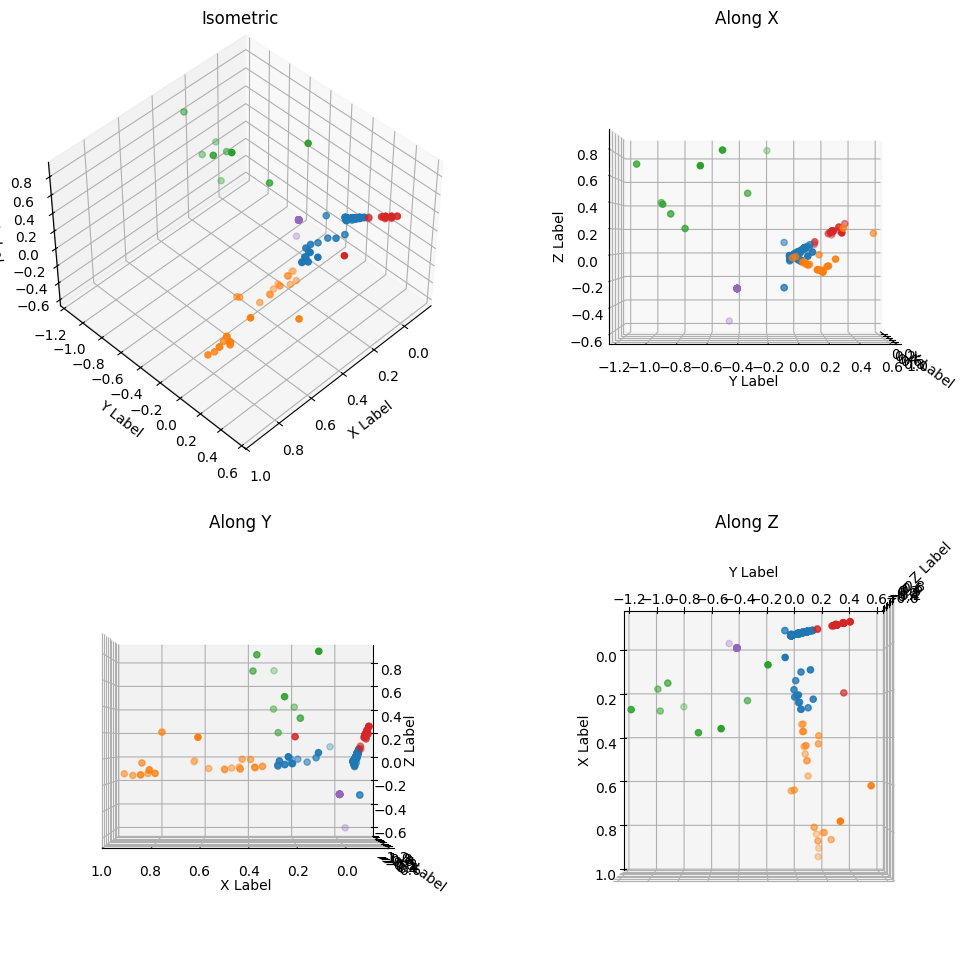

In [60]:
from mpl_toolkits import mplot3d # Allows us to use `view_init()`

def gridview_3d(data, labels):
    titles = ['Isometric', 'Along X', 'Along Y', 'Along Z']
    elevation = [45, 0, 0, 90]
    azimuth = [45, 0, 90, 0]


    figure, axes = plt.subplots(2,2,figsize=(12,12), subplot_kw=dict(projection='3d'))

    for i, ax in enumerate(axes.flat):
        print(f'Plotting {titles[i]}...')
        for label in np.unique(labels):
            ax.scatter(data[labels==label, 0], data[labels==label, 1], data[labels==label, 2])
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title(titles[i])
        ax.view_init(elevation[i], azimuth[i]) # Allows us to change the orientation


    plt.show()

gridview_3d(reduced, y_kmeans)

In [61]:
pd.DataFrame(pca.components_, columns=df_groups_clustering.columns, index=['PC-x', 'PC-y', 'PC-z'])

,controllables_norm,controllers_norm,path_da_nedges_norm,members_norm,n_in_path_da_norm,users_mean-group_control_norm
PC-x,0.189285,-0.103579,0.971607,-0.028067,0.092925,-0.0
PC-y,-0.539071,0.800461,0.204256,-0.043117,-0.158382,-0.0
PC-z,0.709827,0.557056,-0.117141,-0.263862,0.320139,-0.0


In [62]:
df_groups["k_lavel"] = y_kmeans

In [63]:
df_groups["k_lavel"].value_counts()

,count
k_lavel,
0,372
3,38
1,28
2,10
4,9


In [64]:
df_groups.groupby("k_lavel")["control_risk_norm_100"].mean()

,control_risk_norm_100
k_lavel,
0,0.207631
1,0.303526
2,0.328959
3,0.253395
4,0.149309


In [65]:
df_groups.sort_values(by="control_risk_norm_100", ascending=False).head(10).k_lavel.value_counts()

,count
k_lavel,
1,6
2,4


In [68]:
df_groups.sort_values(by="control_risk_norm_100", ascending=False).head(30).k_lavel.value_counts()

,count
k_lavel,
1,18
2,7
0,4
3,1


In [69]:
df_groups[['name','controllables', 'controllers', 'members','membership', 'admincount', 'admin_tier_0', 'path_da_nnodes', 'path_da_nedges', 'control_risk_norm_100','n_in_path_da', 'users_mean-group_control_norm','k_lavel']].sort_values(by="control_risk_norm_100", ascending=False).head(20)

,name,controllables,controllers,members,membership,admincount,admin_tier_0,path_da_nnodes,path_da_nedges,control_risk_norm_100,n_in_path_da,users_mean-group_control_norm,k_lavel
16,DE-DAS-DISTLIST1@MYLAB.LOCAL,3363.0,255.0,23.0,0.0,False,False,5.0,6.0,0.433929,389.0,0.0,2
178,DA-EST-DISTLIST1@MYLAB.LOCAL,2513.0,379.0,59.0,0.0,False,False,0.0,0.0,0.417375,399.0,0.0,2
50,RO-ARJ-DISTLIST1@MYLAB.LOCAL,3363.0,168.0,52.0,0.0,False,False,5.0,6.0,0.403773,361.0,0.0,2
4,DOMAIN ADMINS@MYLAB.LOCAL,3571.0,4.0,4.0,6.0,True,True,0.0,0.0,0.398379,717.0,0.0,2
297,PA-COM-DISTLIST1@MYLAB.LOCAL,552.0,362.0,29.0,0.0,False,False,12.0,25.0,0.389980,83.0,0.0,1
371,EV-JCH-DISTLIST1@MYLAB.LOCAL,4.0,435.0,28.0,5.0,False,False,16.0,22.0,0.363652,2.0,0.0,1
387,BE-240-ADMINGROUP1@MYLAB.LOCAL,116.0,276.0,25.0,0.0,False,False,15.0,28.0,0.348144,15.0,0.0,1
347,TA-CHAPARRIT-DISTLIST1@MYLAB.LOCAL,106.0,220.0,69.0,8.0,False,False,16.0,30.0,0.341988,16.0,0.0,1
351,JO-PIPOMORRI-DISTLIST1@MYLAB.LOCAL,22.0,219.0,184.0,0.0,False,False,13.0,26.0,0.333987,55.0,0.0,1
328,JE-CAR-DISTLIST1@MYLAB.LOCAL,27.0,243.0,52.0,3.0,False,False,14.0,27.0,0.332327,18.0,0.0,1


## DBSCAN

In [70]:
df_groups_clustering = df_groups[['controllables_norm','controllers_norm', 'path_da_nedges_norm', 'members_norm', 'n_in_path_da_norm','users_mean-group_control_norm']]

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a scaled copy of the data
scaler = StandardScaler()
scaler.fit(df_groups_clustering)
scaled = scaler.transform(df_groups_clustering)

# Apply a PCA 3 to the scaled data
pca = PCA(3)
pca.fit(scaled)
reduced = pca.transform(scaled)

# Cluster the scaled data using the values provided in the instructions
dbscan = DBSCAN(n_jobs=-1, min_samples=5, eps=0.8)
dbscan.fit(scaled)

# Copy the labels
y_labels = dbscan.labels_
np.unique(y_labels)

array([-1,  0,  1,  2,  3,  4])

Plotting Isometric...
Plotting Along X...
Plotting Along Y...
Plotting Along Z...


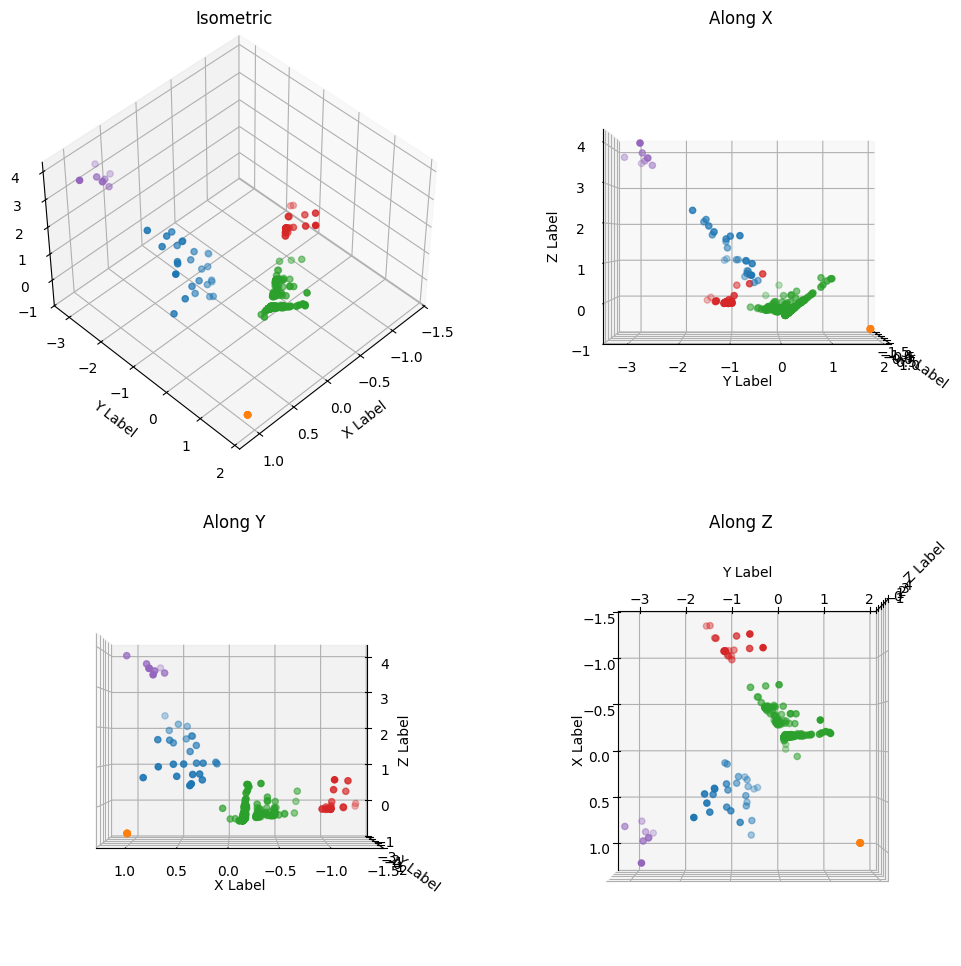

Plotting Isometric...
Plotting Along X...
Plotting Along Y...
Plotting Along Z...


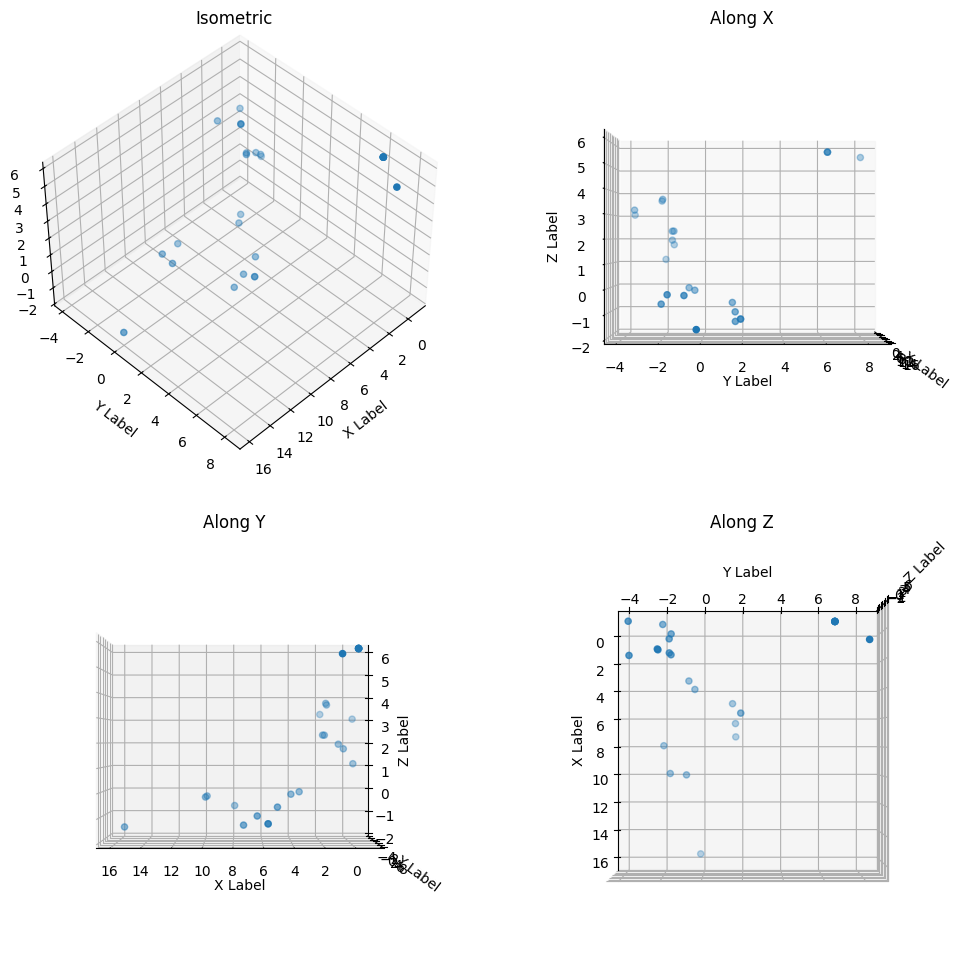

In [72]:
from mpl_toolkits import mplot3d # Allows us to use `view_init()`
import matplotlib.pyplot as plt

def gridview_3d(data, labels):
    titles = ['Isometric', 'Along X', 'Along Y', 'Along Z']
    elevation = [45, 0, 0, 90]
    azimuth = [45, 0, 90, 0]


    figure, axes = plt.subplots(2,2,figsize=(12,12), subplot_kw=dict(projection='3d'))

    for i, ax in enumerate(axes.flat):
        print(f'Plotting {titles[i]}...')
        for label in np.unique(labels):
            ax.scatter(data[labels==label, 0], data[labels==label, 1], data[labels==label, 2])
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title(titles[i])
        ax.view_init(elevation[i], azimuth[i]) # Allows us to change the orientation


    plt.show()

gridview_3d(reduced[y_labels!=-1], y_labels[y_labels!=-1])
gridview_3d(reduced[y_labels==-1], y_labels[y_labels==-1])

In [73]:
df_groups["k_lavel"] = y_labels

In [74]:
df_groups.groupby("k_lavel")["control_risk_norm_100"].mean()

,control_risk_norm_100
k_lavel,
-1,0.321151
0,0.257623
1,0.134896
2,0.204862
3,0.254485
4,0.332524


In [75]:
df_groups["k_lavel"].value_counts()

,count
k_lavel,
2,357
3,33
0,26
-1,25
1,8
4,8


In [76]:
df_groups.sort_values(by="control_risk_norm_100", ascending=False).head(1000)["k_lavel"].value_counts()

,count
k_lavel,
2,357
3,33
0,26
-1,25
4,8
1,8


In [77]:
df_groups[['name','controllables', 'controllers', 'members','membership', 'admincount', 'admin_tier_0', 'path_da_nnodes', 'path_da_nedges', 'control_risk_norm_100','n_in_path_da', 'users_mean-group_control_norm','k_lavel']].sort_values(by="control_risk_norm_100", ascending=False).head(5)

,name,controllables,controllers,members,membership,admincount,admin_tier_0,path_da_nnodes,path_da_nedges,control_risk_norm_100,n_in_path_da,users_mean-group_control_norm,k_lavel
16,DE-DAS-DISTLIST1@MYLAB.LOCAL,3363.0,255.0,23.0,0.0,False,False,5.0,6.0,0.433929,389.0,0.0,-1
178,DA-EST-DISTLIST1@MYLAB.LOCAL,2513.0,379.0,59.0,0.0,False,False,0.0,0.0,0.417375,399.0,0.0,-1
50,RO-ARJ-DISTLIST1@MYLAB.LOCAL,3363.0,168.0,52.0,0.0,False,False,5.0,6.0,0.403773,361.0,0.0,-1
4,DOMAIN ADMINS@MYLAB.LOCAL,3571.0,4.0,4.0,6.0,True,True,0.0,0.0,0.398379,717.0,0.0,-1
297,PA-COM-DISTLIST1@MYLAB.LOCAL,552.0,362.0,29.0,0.0,False,False,12.0,25.0,0.389980,83.0,0.0,-1


## AI Embedings

In [ ]:
#!pip install ollama

In [ ]:
df_users_txt = df_users.copy()

In [ ]:
df_users_txt.columns

Index(['Unnamed: 0', 'adminRights', 'constrainedDelegation', 'controllables',
       'controllers', 'dcomRights', 'gpos', 'groupMembership', 'admincount',
       'description', 'distinguishedname', 'domain', 'domainsid',
       'dontreqpreauth', 'enabled', 'encryptedtextpwdallowed', 'gmsa',
       'hasspn', 'isaclprotected', 'lastlogon', 'lastlogontimestamp',
       'lastseen', 'lockedout', 'logonscriptenabled', 'name', 'objectid',
       'passwordcantchange', 'passwordexpired', 'passwordnotreqd',
       'pwdlastset', 'pwdneverexpires', 'samaccountname', 'sensitive',
       'serviceprincipalnames', 'sidhistory', 'smartcardrequired',
       'supportedencryptiontypes', 'system_tags', 'trustedtoauth',
       'unconstraineddelegation', 'usedeskeyonly', 'useraccountcontrol',
       'whencreated', 'psRemoteRights', 'rdpRights', 'sessions', 'sqlAdmin',
       'admin_tier_0', 'path_da_nnodes', 'path_da_nedges', 'path_da_nodes',
       'path_da_edges', 'path_da_nodes_oidlist', 'displayname', 'e

In [ ]:
df_users_txt["text"] = df_users_txt.apply(lambda x: f"Active directory user with risk level {x['control_risk_100']} is able to control {x['controllables']} active directory objects but in the other hand {x['controllables']} can control it. The user has a way to escalate to domain admin in {x['path_da_nedges']} steps, being 0 that the user has not a path to domain admin. {x['n_in_path_da']} another users can use this user to escalate to domain admin.", axis=1)

In [ ]:
import ollama

In [ ]:
model = "nomic-embed-text"

"deepseek-r1:1.5b" -> 19k users -> 41 minutes apply
"deepseek-r1:1.5b" -> 19k users -> ThreadPoolExecutor(4) slow, 18, errors
"deepseek-r1:1.5b" -> 19k users -> swifter 40 o 50 minutos
nomic-embed-text -> joblib 12 min
nomic-embed-text -> swifter 15 min

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
def obtener_embedding(texto):
    resultado = ollama.embed(model=model, input=texto)["embeddings"][0]

    if "embedding" in resultado:
        embedding = resultado["embedding"]

        try:
            json.dumps(embedding)
            return embedding
        except TypeError as e:
            print(f"Error al serializar embedding: {e}")
            return None

    return None

In [ ]:
%%time
with ThreadPoolExecutor(max_workers=18) as executor:
    embeddings = list(executor.map(obtener_embedding, df_users_txt["text"]))

In [ ]:
!pip install swifter

In [ ]:
%%time
from joblib import Parallel, delayed

df_users_txt_min["embeddings"] = Parallel(n_jobs=9, backend="threading")(
    delayed(obtener_embedding)(text) for text in df_users_txt_min["text"]
)

CPU times: total: 49.7 s
Wall time: 12min 19s


In [ ]:
%%time
import swifter

df_users_txt["embeddings"] = df_users_txt_min["text"].swifter.apply(obtener_embedding)

In [ ]:
df_users_txt_min["embedding"] = embeddings

In [ ]:
%%time
df_users_txt_min["embedding"] = df_users_txt_min["text"].apply(lambda text: ollama.embeddings(model=model, prompt=text)["embedding"])

CPU times: total: 41.9 s
Wall time: 12min 49s


### Create similitude matrix

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np

In [ ]:
df_users_txt_min2 = df_users_txt_min.sort_values(by="control_risk_norm_100", ascending=False).head(1000)

In [ ]:
%%time
embedding_matrix = np.vstack(df_users_txt_min2["embedding"].values)

#similarity_matrix = cosine_similarity(embedding_matrix)
similarity_matrix = euclidean_distances(embedding_matrix)

CPU times: total: 375 ms
Wall time: 82 ms


### Plotting

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE

In [ ]:
#Euclidean
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

df_users_txt_min2["TSNE-1"] = reduced_embeddings[:, 0]
df_users_txt_min2["TSNE-2"] = reduced_embeddings[:, 1]

fig = px.scatter(df_users_txt_min2, x="TSNE-1", y="TSNE-2", text=df_users_txt_min2["name"], title="Visualización de Embeddings de Usuarios",
                 labels={"TSNE-1": "Dimensión 1", "TSNE-2": "Dimensión 2"},
                 hover_data=["name", "control_risk_norm_100", "controllables", "controllers", "n_in_path_da", "path_da_nedges"])
fig.update_traces(text=None)

fig.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

df_users_txt_min2["TSNE-1"] = reduced_embeddings[:, 0]
df_users_txt_min2["TSNE-2"] = reduced_embeddings[:, 1]

fig = px.scatter(df_users_txt_min2, x="TSNE-1", y="TSNE-2", text=df_users_txt_min2["name"], title="Visualización de Embeddings de Usuarios",
                 labels={"TSNE-1": "Dimensión 1", "TSNE-2": "Dimensión 2"},
                 hover_data=["name", "control_risk_norm_100", "controllables", "controllers", "n_in_path_da", "path_da_nedges"])
fig.update_traces(text=None)

fig.show()

### Queries

In [ ]:
pregunta = "user more steps to domain admin?"

embedding_pregunta = ollama.embeddings(model=model, prompt=pregunta)["embedding"]

In [ ]:
similarity_scores = euclidean_distances([embedding_pregunta], embedding_matrix)

df_users_txt_min2["similitud"] = similarity_scores[0]

df_sorted = df_users_txt_min2.sort_values(by="similitud", ascending=False).head(5)

df_sorted[["name", "similitud", "control_risk_norm_100", "controllables", "controllers", "n_in_path_da", "path_da_nedges"]]

In [ ]:
similarity_scores = cosine_similarity([embedding_pregunta], embedding_matrix)

df_users_txt_min2["similitud"] = similarity_scores[0]

df_sorted = df_users_txt_min2.sort_values(by="similitud", ascending=False).head(5)

df_sorted[["name", "similitud", "control_risk_norm_100", "controllables", "controllers", "n_in_path_da", "path_da_nedges"]]

In [ ]:
df_users_txt_min2[["name", "similitud", "control_risk_norm_100", "controllables", "controllers", "n_in_path_da"]].sort_values(by="controllables", ascending=False).head(5)